# Project description

This project corresponds to the development of a machine learning model for the prediction of credit scores, produced as the final assignment for the Machine Learning course at Nova SBE during the sprong semester of 2025.

### Group number: 6
### Student IDs:
* Luis de Sousa da Silva (43055)
* Martin Hunger (65604)
* Mikel Irizar Krinn (63619)
### Project name:

Credit Risk (Project number 11)

## What business problem are you solving?
**Minimizing loan defaults and maximizing portfolio performance by identifying and managing the incremental factors that drive borrower creditworthiness!**

Before giving out loans, banks need to consider, who is applying for the loan and whether the person should be given a loan, based on the expected risk. 
To assess this risk and come to a decision, banks assess credit worthiness of their potential clients, which determines the risk of giving the client a loan and the client not being able to repay the bank. Clients are classified into three categories of credit risk (good, neutral, bad). The goal is to predit and classify each person correctly, so that the bank ultimately does not give out loans to people not being able to repay them. When classifying each person, the bank has lots of information, in our case almost 30 variables - spanning income, outstanding debt, repayment history, credit inquiries, and more. By training a predictive model on this data, we can automate credit-risk assessments, reduce approval times, and help lenders balance portfolio growth against default risk.


## What is the machine learning problem that you are solving?

We treat credit-risk assessment as a supervised, three-way classification problem—labeling each borrower as poor, standard, or good risk using about 30 engineered features. We split the data into training, validation, and hold-out test sets, then use the validation set to tune our model via halving random search. To counter data imbalance we use SMOTE-NC. Once the best hyperparameters are found for all our machine learning models we train, we retrain on the combined training and validation data and report final performance on the untouched test set. To understand why the model makes each prediction, we use SHAP to highlight the most influential risk drivers.



# Import Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import difflib


In [103]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC
from scipy.stats import loguniform

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from torchvision import datasets, transforms
from torchinfo import summary
from torchmetrics.regression import MeanAbsoluteError
from  pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

import os
import json
import sklearn

In [104]:
# Had to "pip install openpyxl"
!pip install openpyxl
dataset = pd.read_excel("pr11_credit_scores.xlsx")


# EDA

In [105]:
dataset.info()

# The fact that we have some variables as objects, when they should be strings or numbers, points us to the fact that there are sveral data types mixed together (which should not happen) and alter us to data cleaningdataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       99909 non-null   object 
 5   SSN                       99909 non-null   object 
 6   Occupation                99909 non-null   object 
 7   Annual_Income             99909 non-null   object 
 8   Monthly_Inhand_Salary     84920 non-null   float64
 9   Num_Bank_Accounts         99909 non-null   float64
 10  Num_Credit_Card           99909 non-null   float64
 11  Interest_Rate             99909 non-null   float64
 12  Num_of_Loan               99909 non-null   object 
 13  Type_of_Loan              88509 non-null   ob

Some columns are marked as object type when they should be numbers or strings (e.g. Age, Annual_Income). This means there are mixed data types in those columns, so we’ll need to clean the data.

In [106]:
dataset.describe(include="all")

ID Customer_ID   Month    Name      Age        SSN Occupation  \
count   100000      100000  100000   90015  99909.0      99909      99909   
unique  100000       12500      44   10139   1799.0      12501         31   
top     0x1602   CUS_0xd40  August  Langep     38.0  #F%$D@*&8    _______   
freq         1           8   12384      44   2831.0       5565       7055   
mean       NaN         NaN     NaN     NaN      NaN        NaN        NaN   
std        NaN         NaN     NaN     NaN      NaN        NaN        NaN   
min        NaN         NaN     NaN     NaN      NaN        NaN        NaN   
25%        NaN         NaN     NaN     NaN      NaN        NaN        NaN   
50%        NaN         NaN     NaN     NaN      NaN        NaN        NaN   
75%        NaN         NaN     NaN     NaN      NaN        NaN        NaN   
max        NaN         NaN     NaN     NaN      NaN        NaN        NaN   

       Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count          99909           84920.000000       99909.000000   
unique         18936                    NaN                NaN   
top         17273.83                    NaN                NaN   
freq              16                    NaN                NaN   
mean             NaN            4194.071131          17.104395   
std              NaN            3183.605038         117.454091   
min              NaN             303.645417          -1.000000   
25%              NaN            1625.597917           3.000000   
50%              NaN            3093.745000           6.000000   
75%              NaN            5957.448333           7.000000   
max              NaN           15204.633333        1798.000000   

        Num_Credit_Card  Interest_Rate  Num_of_Loan   Type_of_Loan  \
count      99909.000000   99909.000000      99909.0          88509   
unique              NaN            NaN        434.0           6260   
top                 NaN            NaN          3.0  Not Specified   
freq                NaN            NaN      14368.0           1406   
mean          22.495621      72.469027          NaN            NaN   
std          129.115463     466.383442          NaN            NaN   
min            0.000000       1.000000          NaN            NaN   
25%            4.000000       8.000000          NaN            NaN   
50%            5.000000      13.000000          NaN            NaN   
75%            7.000000      20.000000          NaN            NaN   
max         1499.000000    5797.000000          NaN            NaN   

        Delay_from_due_date  Num_of_Delayed_Payment Changed_Credit_Limit  \
count         100000.000000                 92998.0               100000   
unique                  NaN                   762.0                 4384   
top                     NaN                    19.0                    _   
freq                    NaN                  5327.0                 2091   
mean              21.068780                     NaN                  NaN   
std               14.860104                     NaN                  NaN   
min               -5.000000                     NaN                  NaN   
25%               10.000000                     NaN                  NaN   
50%               18.000000                     NaN                  NaN   
75%               28.000000                     NaN                  NaN   
max               67.000000                     NaN                  NaN   

        Num_Credit_Inquiries Credit_Mix Outstanding_Debt  \
count           98035.000000     100000           100000   
unique                   NaN          4            13178   
top                      NaN   Standard          1360.45   
freq                     NaN      36479               24   
mean               27.754251        NaN              NaN   
std               193.177339        NaN              NaN   
min                 0.000000        NaN              NaN   
25%                 3.000000        NaN              NaN   


In [107]:
pd.set_option('display.max_columns', None)
dataset.head(24)

ID Customer_ID     Month             Name   Age          SSN  \
0   0x1602   CUS_0xd40   January    Aaron Maashoh    23  821-00-0265   
1   0x1603   CUS_0xd40  February    Aaron Maashoh    23  821-00-0265   
2   0x1604   CUS_0xd40     March    Aaron Maashoh  -500  821-00-0265   
3   0x1605   CUS_0xd40     April    Aaron Maashoh    23  821-00-0265   
4   0x1606   CUS_0xd40       May    Aaron Maashoh    23  821-00-0265   
5   0x1607   CUS_0xd40      June    Aaron Maashoh    23  821-00-0265   
6   0x1608   CUS_0xd40      July    Aaron Maashoh    23  821-00-0265   
7   0x1609   CUS_0xd40    August              NaN    23    #F%$D@*&8   
8   0x160e  CUS_0x21b1   January  Rick Rothackerj   28_  004-07-5839   
9   0x160f  CUS_0x21b1  February  Rick Rothackerj    28  004-07-5839   
10  0x1610  CUS_0x21b1     March  Rick Rothackerj    28  004-07-5839   
11  0x1611  CUS_0x21b1     April  Rick Rothackerj    28  004-07-5839   
12  0x1612  CUS_0x21b1       May  Rick Rothackerj    28  004-07-5839   
13  0x1613  CUS_0x21b1      June  Rick Rothackerj    28  004-07-5839   
14  0x1614  CUS_0x21b1      July  Rick Rothackerj    28  004-07-5839   
15  0x1615  CUS_0x21b1    August  Rick Rothackerj    28  004-07-5839   
16  0x161a  CUS_0x2dbc   January           Langep    34  486-85-3974   
17  0x161b  CUS_0x2dbc  February              NaN    34  486-85-3974   
18  0x161c  CUS_0x2dbc     March           Langep    34  486-85-3974   
19  0x161d  CUS_0x2dbc     April           Langep    34  486-85-3974   
20  0x161e  CUS_0x2dbc       May           Langep    34  486-85-3974   
21  0x161f  CUS_0x2dbc      June           Langep    34  486-85-3974   
22  0x1620  CUS_0x2dbc      July              NaN    34  486-85-3974   
23  0x1621  CUS_0x2dbc    August           Langep    34  486-85-3974   

   Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0   Scientist      19114.12            1824.843333                3.0   
1   Scientist      19114.12                    NaN                3.0   
2   Scientist      19114.12                    NaN                3.0   
3   Scientist      19114.12                    NaN                3.0   
4   Scientist      19114.12            1824.843333                3.0   
5   Scientist      19114.12                    NaN                3.0   
6   Scientist      19114.12            1824.843333                3.0   
7   Scientist      19114.12            1824.843333                3.0   
8     _______      34847.84            3037.986667                2.0   
9     Teacher      34847.84            3037.986667                2.0   
10    Teacher     34847.84_            3037.986667                2.0   
11    Teacher      34847.84                    NaN                2.0   
12    Teacher      34847.84            3037.986667                2.0   
13    Teacher      34847.84            3037.986667                2.0   
14    Teacher      34847.84                    NaN                2.0   
15    Teacher      34847.84            3037.986667                2.0   
16    _______     143162.64           12187.220000                1.0   
17   Engineer     143162.64           12187.220000                1.0   
18    _______     143162.64                    NaN                1.0   
19   Engineer     143162.64           12187.220000                1.0   
20    _______     143162.64           12187.220000                1.0   
21   Engineer     143162.64           12187.220000                1.0   
22   Engineer     143162.64           12187.220000                1.0   
23   Engineer     143162.64           12187.220000                1.0   

    Num_Credit_Card  Interest_Rate Num_of_Loan  \
0               4.0            3.0           4   
1               4.0            3.0           4   
2               4.0            3.0           4   
3               4.0            3.0           4   
4               4.0            3.0           4   
5               4.0            3.0           4   
6               4.0            

**Fixing Data Types**

As we noticed some columns had the wrong data types because of messy or inconsistent values. To fix this, we went through each column and made sure categorical fields like IDs and occupations were stored as text, while numeric fields like age and income were properly converted to numbers. Any values that couldn't be converted automatically were set to missing so we can handle them separately.

In [108]:
categorical_variables = ["ID", "Customer_ID", "Month", "Name", "SSN", "Occupation", "Type_of_Loan", "Credit_Mix", "Credit_History_Age", "Payment_of_Min_Amount", "Payment_Behaviour", "Credit_Score"]
numerical_variables = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Outstanding_Debt", "Credit_Utilization_Ratio", "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance"]


for column in dataset.columns:
    if column in categorical_variables and dataset[column].dtype not in ["object", "category"]:
        dataset[column] = dataset[column].astype("str").astype("category")
    elif column in numerical_variables and dataset[column].dtype not in ["float64", "int64"]:
        dataset[column] = pd.to_numeric(dataset[column], errors="coerce")



In [ ]:
dataset[dataset.duplicated()]

This means that we don´t have any duplicates in our dataset

In [109]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       94974 non-null   float64
 5   SSN                       99909 non-null   object 
 6   Occupation                99909 non-null   object 
 7   Annual_Income             92932 non-null   float64
 8   Monthly_Inhand_Salary     84920 non-null   float64
 9   Num_Bank_Accounts         99909 non-null   float64
 10  Num_Credit_Card           99909 non-null   float64
 11  Interest_Rate             99909 non-null   float64
 12  Num_of_Loan               95127 non-null   float64
 13  Type_of_Loan              88509 non-null   ob

**Exploring the Data Through Visualizations**

Now that we've fixed the data types, we're creating visualizations to understand each variable better. For numerical columns, we plot histograms showing the distribution along with reference lines for the mean, 95th percentile, and 99th percentile - these help spot potential outliers. By overlaying the 95th and 99th percentiles histograms, we quickly see how heavily right-skewed the a variables distribution is and where the true bulk of values lie. Those percentile lines help us to identify outliers beyond the 99th percentile that might unduly influence models or decide sensible caps or thresholds (e.g. winsorizing at the 95th percentile) to reduce noise.
We also include the count of missing values and unique values in each plot title.

For categorical variables with 20 or fewer categories, we show a simple bar chart of all categories. When there are more than 20 categories, we display the top 19 most frequent ones and group the rest into an "Other" category to keep the visualization clean. Every plot clearly shows what percentage of the data each category represents.

The visualizations serve two main purposes: they help us understand the shape of our data and quickly identify any unusual patterns that might need further investigation before modeling

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


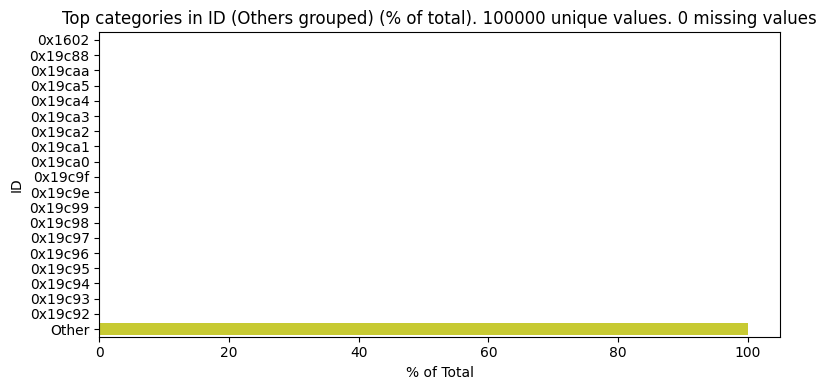

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


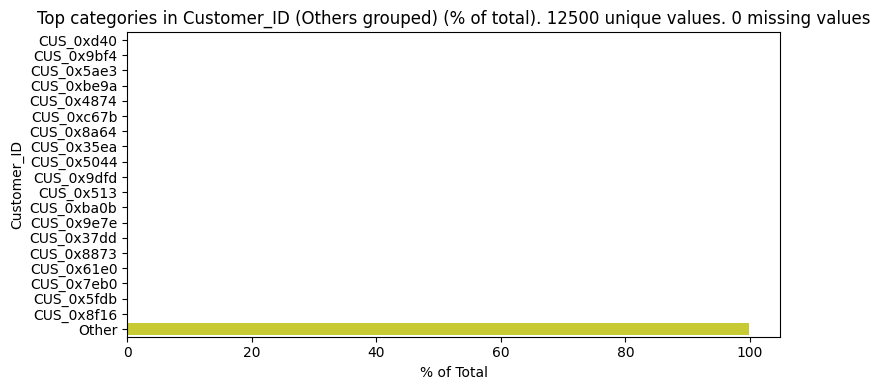

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


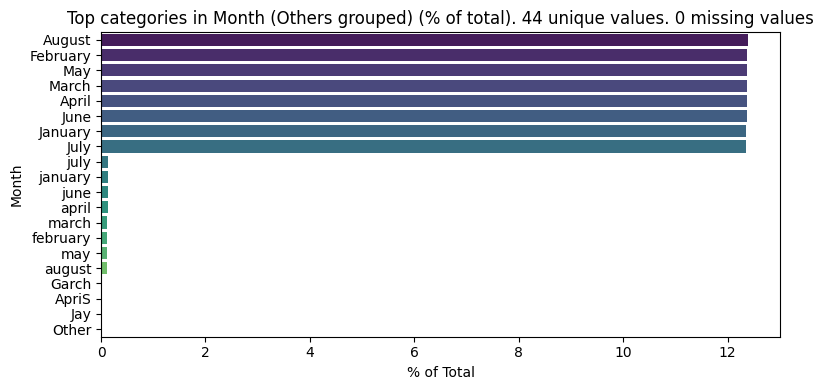

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


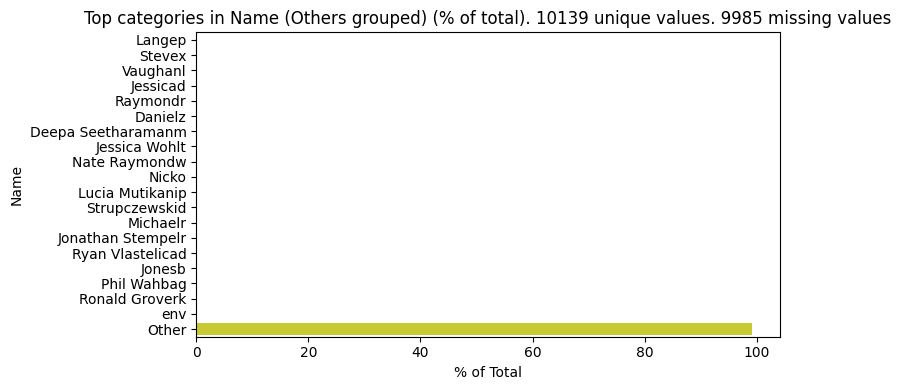

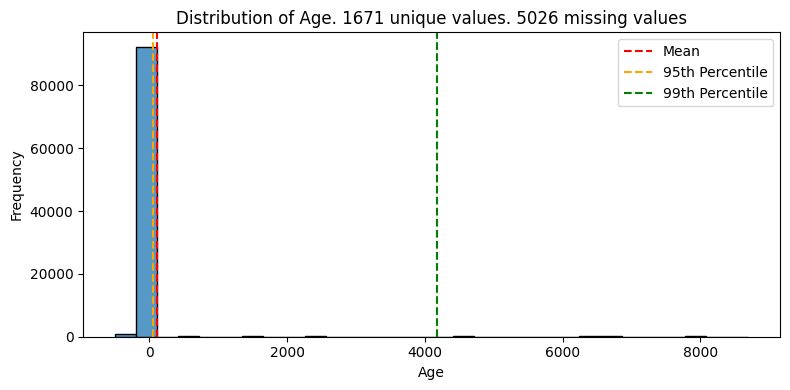

<Figure size 640x480 with 0 Axes>

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


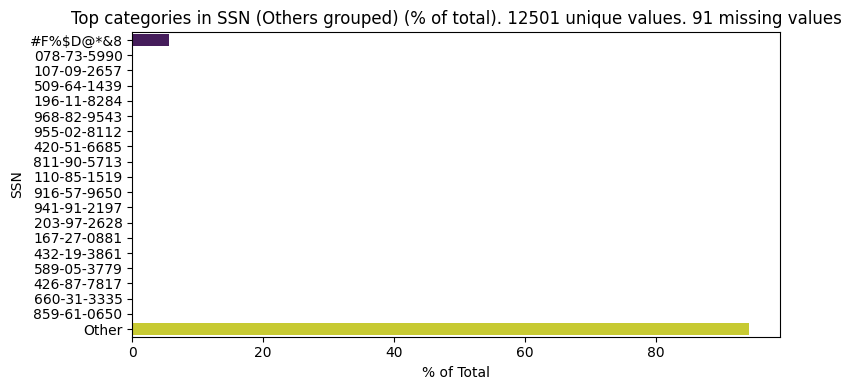

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


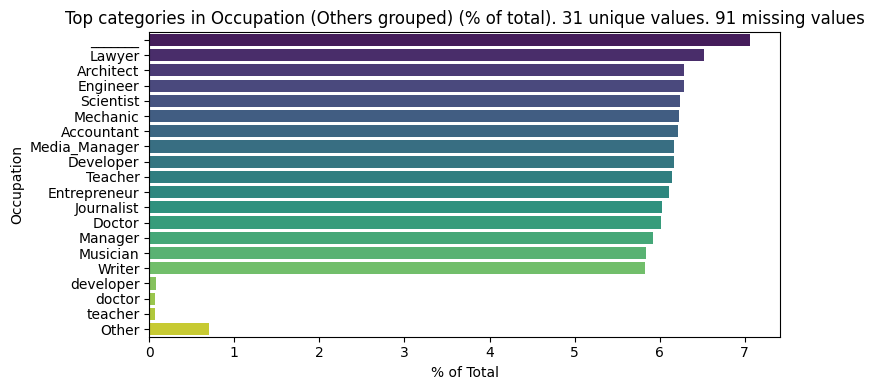

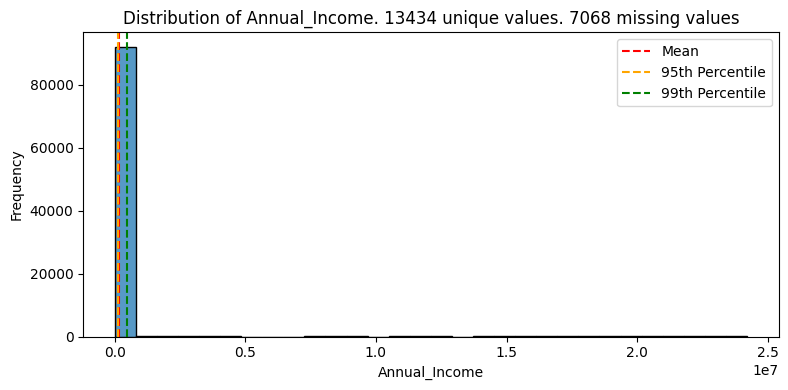

<Figure size 640x480 with 0 Axes>

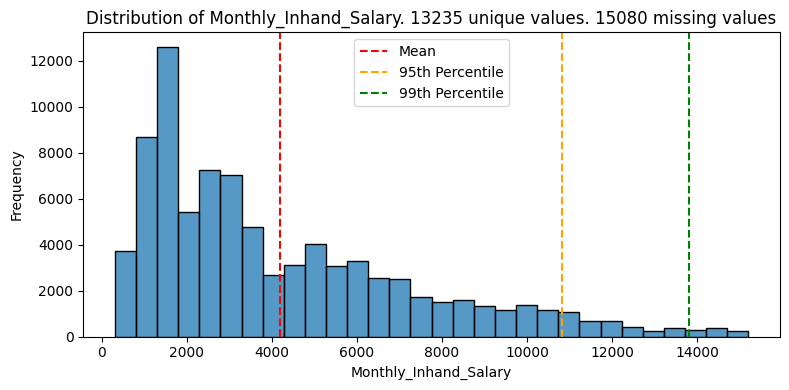

<Figure size 640x480 with 0 Axes>

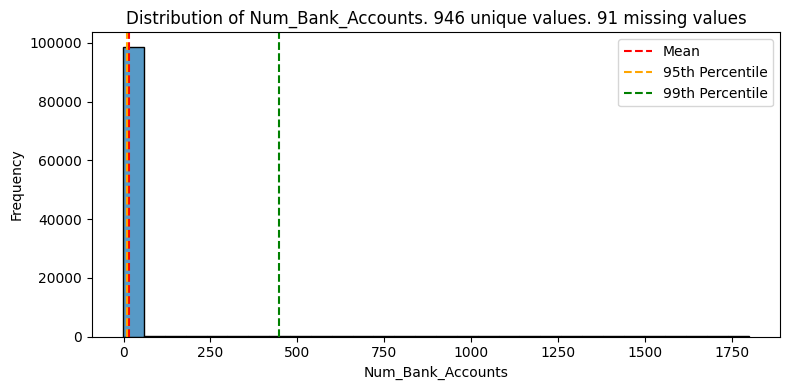

<Figure size 640x480 with 0 Axes>

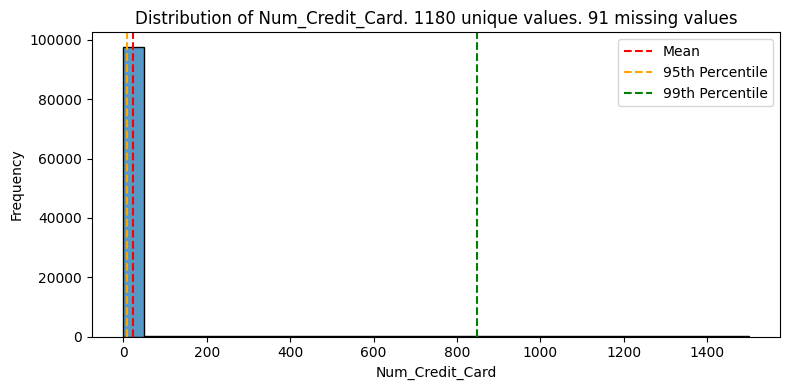

<Figure size 640x480 with 0 Axes>

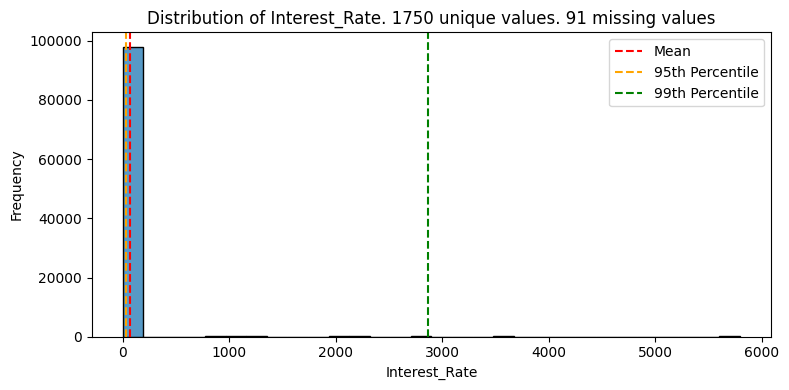

<Figure size 640x480 with 0 Axes>

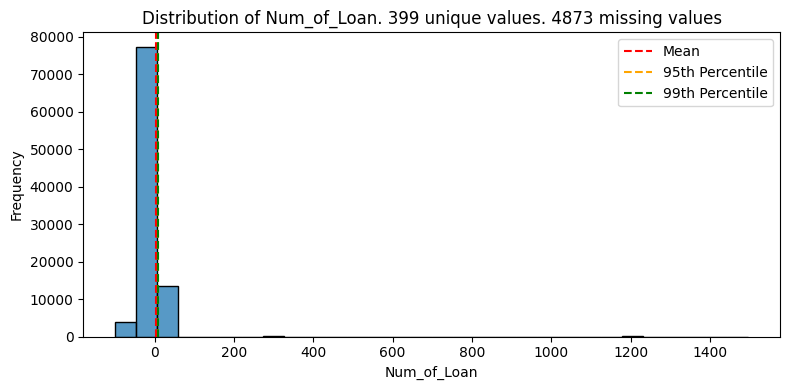

<Figure size 640x480 with 0 Axes>

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


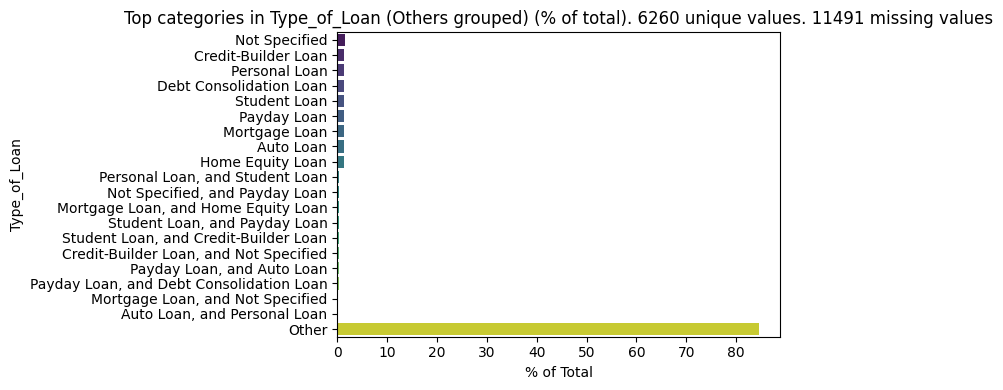

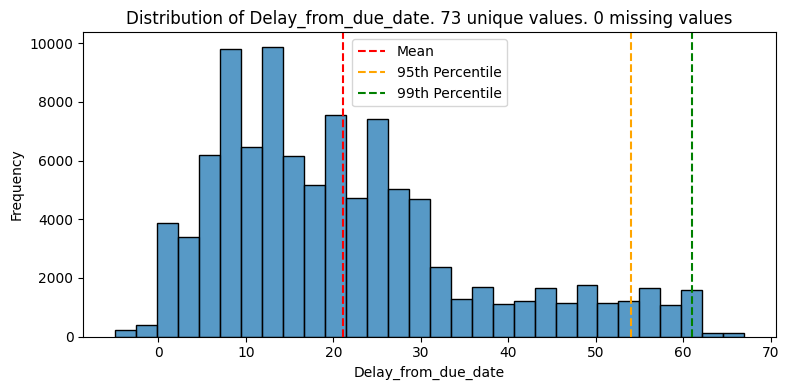

<Figure size 640x480 with 0 Axes>

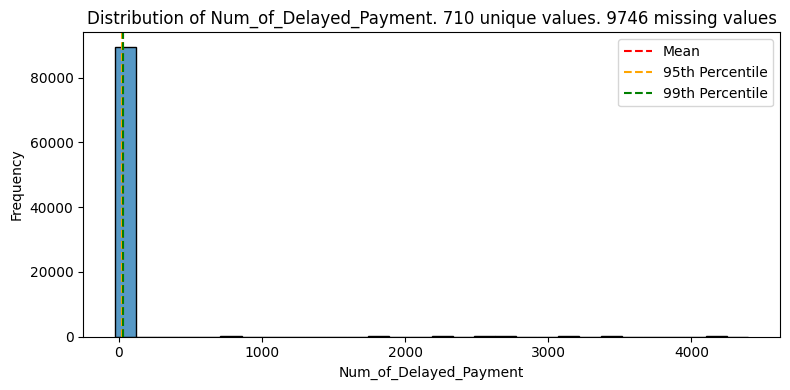

<Figure size 640x480 with 0 Axes>

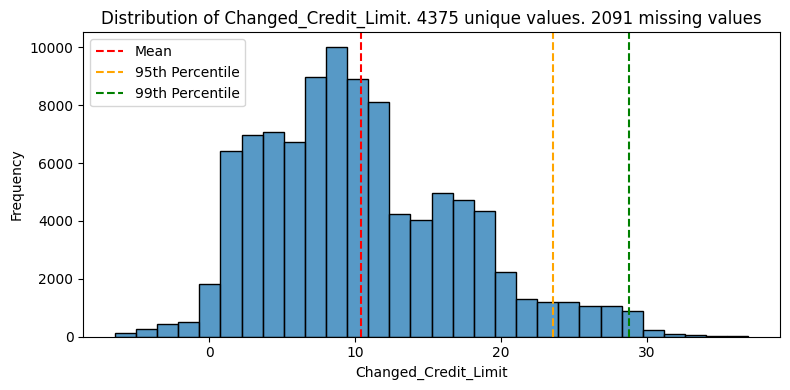

<Figure size 640x480 with 0 Axes>

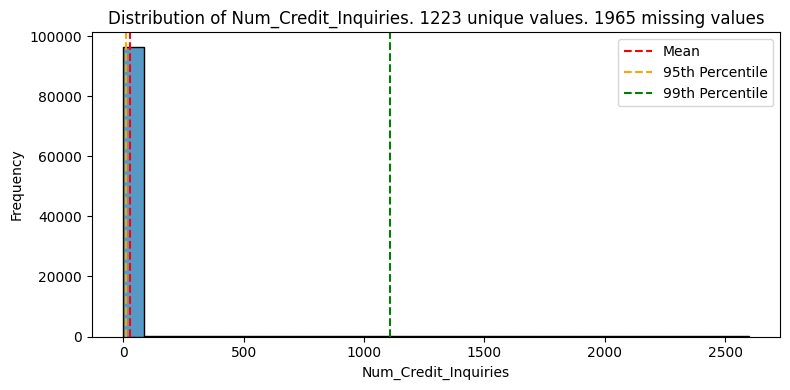

<Figure size 640x480 with 0 Axes>

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


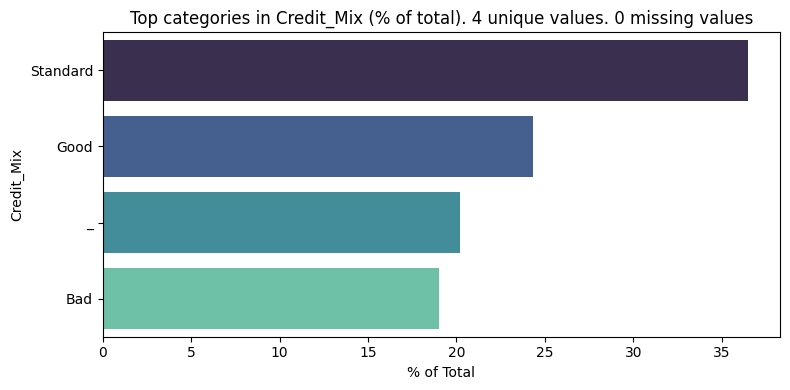

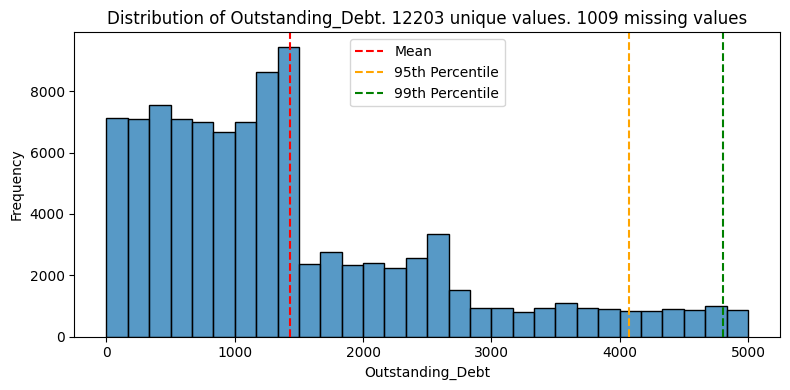

<Figure size 640x480 with 0 Axes>

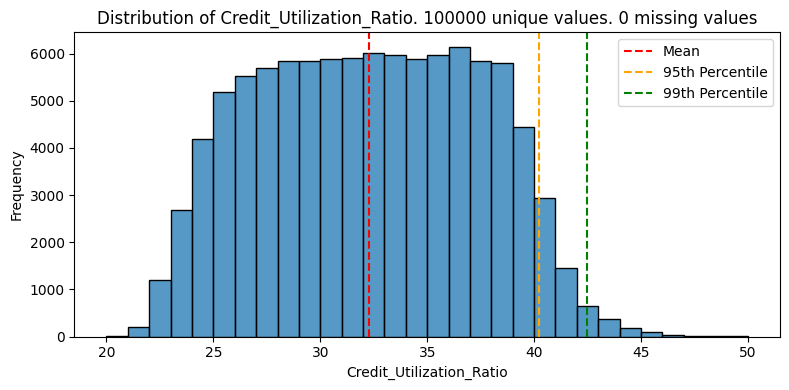

<Figure size 640x480 with 0 Axes>

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')


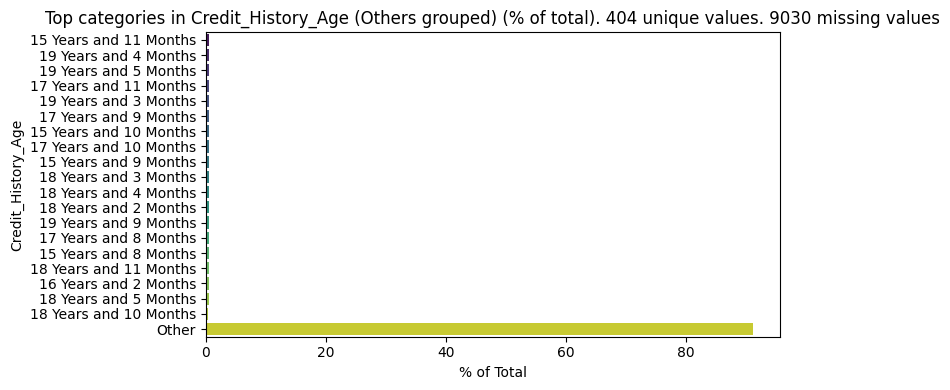

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


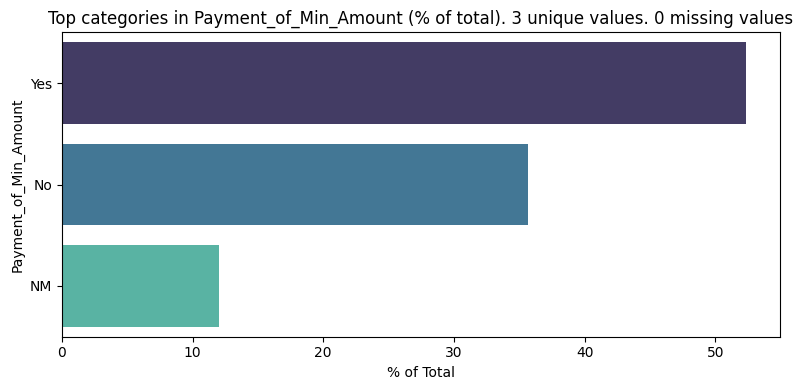

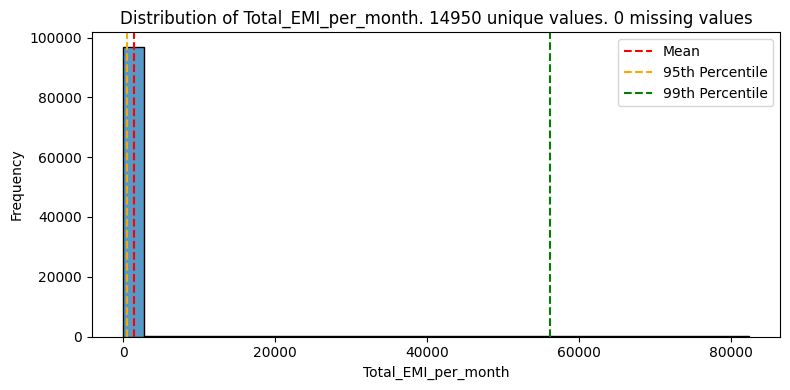

<Figure size 640x480 with 0 Axes>

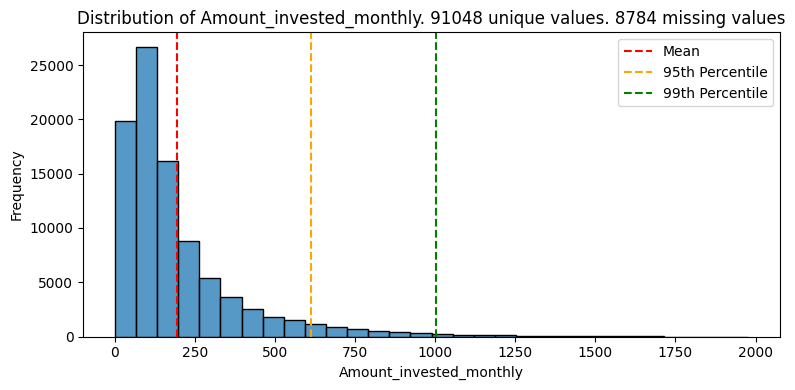

<Figure size 640x480 with 0 Axes>

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


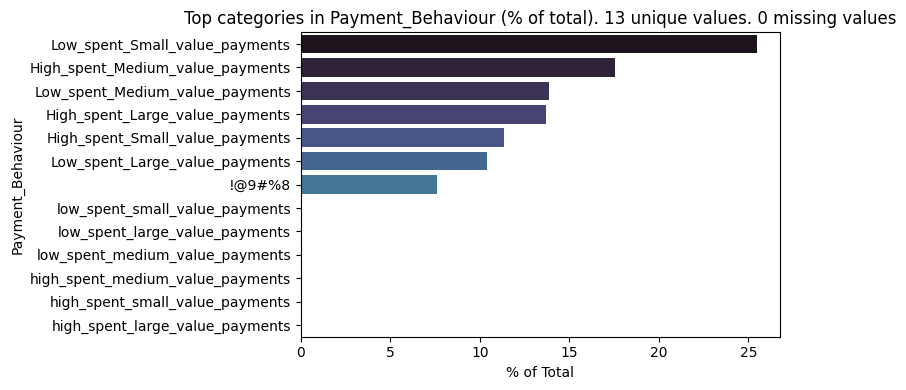

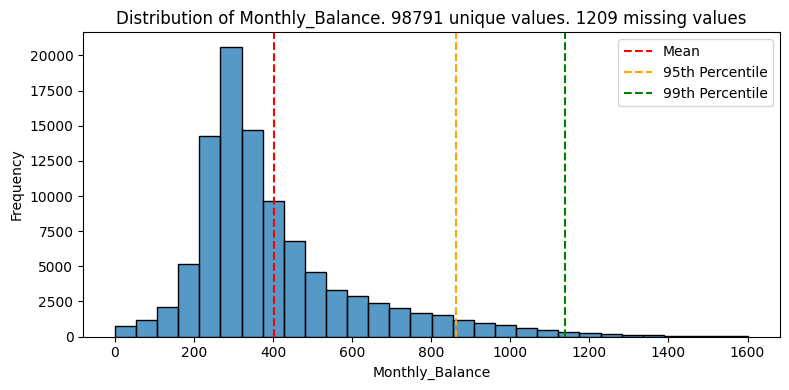

<Figure size 640x480 with 0 Axes>

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/3314124087.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


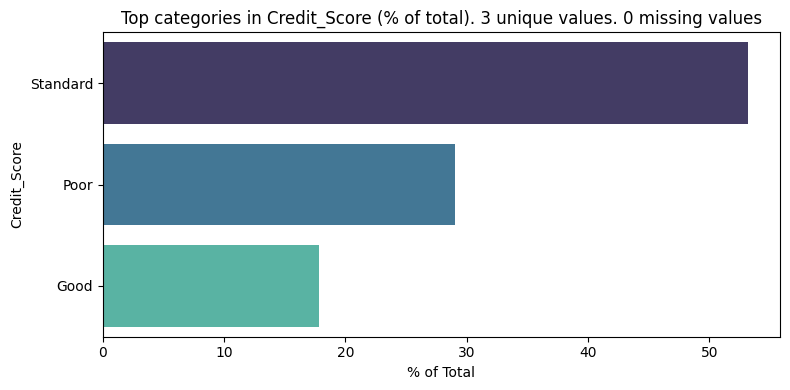

In [110]:
for variable in dataset.columns:
    plt.figure(figsize=(8, 4))

    num_unique = dataset[variable].nunique()
    num_missing = dataset[variable].isnull().sum()

    if variable in numerical_variables: # Numerical variables

        summary_stats = dataset[variable].describe(percentiles=[0.95, 0.99]).transpose()
        mean = summary_stats['mean']
        p95 = summary_stats['95%']
        p99 = summary_stats['99%']

        sns.histplot(dataset[variable], bins=30)
        plt.axvline(mean, color='red', linestyle='--', label='Mean')
        plt.axvline(p95, color='orange', linestyle='--', label='95th Percentile')
        plt.axvline(p99, color='green', linestyle='--', label='99th Percentile')

        plt.title(f'Distribution of {variable}. {num_unique} unique values. {num_missing} missing values')
        plt.xlabel(variable)
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

    elif variable in categorical_variables and dataset[variable].nunique() <= 20:
        value_counts = dataset[variable].value_counts(normalize=True) * 100
        sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')
        plt.title(f'Top categories in {variable} (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)

    elif variable in categorical_variables:
        # Calculate percentage distribution for all categories
        value_counts = dataset[variable].value_counts(normalize=True) * 100
        top_19 = value_counts.head(19)
        other = value_counts[19:].sum()
        value_counts_plot = pd.concat([top_19, pd.Series({'Other': other})])

        sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')
        plt.title(f'Top categories in {variable} (Others grouped) (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)


    plt.tight_layout()
    plt.show()


# Feature Engineering

**Processing Loan Type Data**

Since customers often have multiple loan types, we have to find  a way to represent this information effectively. Instead of traditional one-hot encoding (which assumes single categories), we used multi-label encoding to capture all loan types per customer. Here's how we did it:

First, we cleaned and standardized the loan type strings by removing inconsistencies in formatting. Then we transformed these into binary columns (one per loan type) where each customer gets marked for every loan they hold. Finally, we visualized the distribution to see which loans are most common across our customer base.

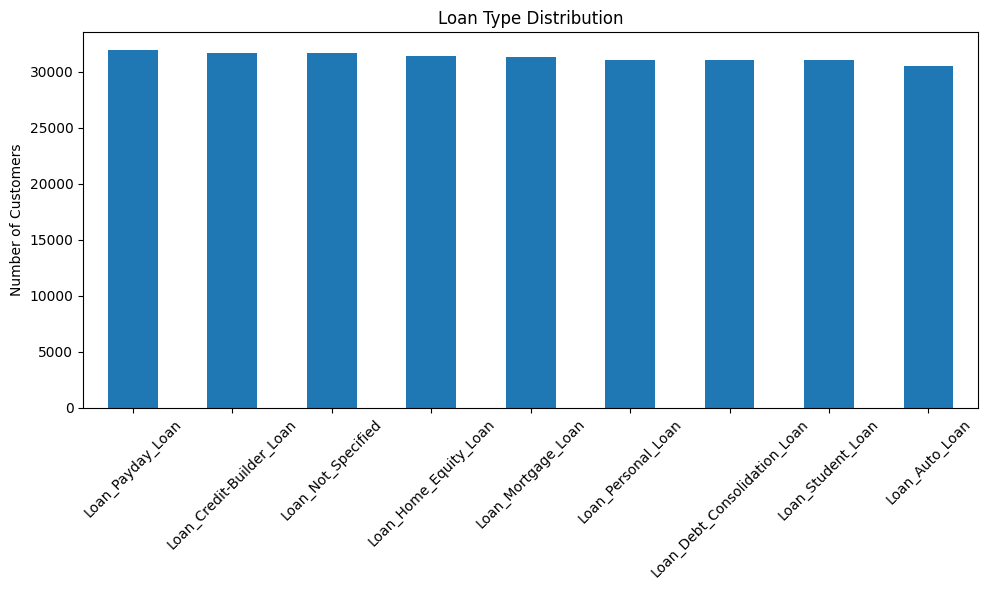

In [111]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# Clean and split the loan strings
loans = (
    dataset['Type_of_Loan'].fillna('')
       .str.replace(r'\s+and\s+', ',', regex=True)
       .str.replace(r',+', ',', regex=True)
       .str.strip(' ,')
)
loan_lists = loans.str.split(',').apply(lambda toks: [t.strip() for t in toks if t.strip()])

# Multi-hot encode
mlb = MultiLabelBinarizer()
dummies = pd.DataFrame(
    mlb.fit_transform(loan_lists),
    columns=['Loan_' + c.replace(' ', '_').title() for c in mlb.classes_],
    index=dataset.index
)

# Merge and drop original
dataset = pd.concat([dataset, dummies], axis=1).drop(columns=['Type_of_Loan'])

# Plot distribution
counts = dummies.sum().sort_values(ascending=False)
counts.plot.bar(figsize=(10,6), rot=45, title='Loan Type Distribution')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()


**Checking Our Loan Categories**

Before moving forward, we want to see exactly which loan types our encoding process identified. This quick check shows us all the unique loan categories that were turned into separate columns during the multi-label encoding. Knowing these helps us verify our data transformation worked as expected and gives us visibility into all the loan types present in our dataset.

In [112]:
dummies = mlb.classes_.tolist()
print(dummies)

['Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan', 'Personal Loan', 'Student Loan']


**Creating More Meaningful Financial Features**

To better assess borrower risk, we developed several key financial ratios and transformations:

Debt-to-Income (DTI): Shows how much debt a borrower carries relative to their annual earnings - a classic leverage measure.

Log Transforms: Applied to monetary values like debt, income, and EMI payments to normally reduce the impact of extreme values while preserving the overall distribution shape. Let´s see if this is the case later.

Credit History Standardization: Converted text-based credit history (e.g., "2 years 6 months") into numeric months, then categorized them into meaningful buckets (Short/Medium/Long) to help the model recognize common risk thresholds.

Age Groupings: Binned ages into life-stage categories that often correlate with different financial behaviors.

These engineered features help our model better understand the nuanced financial situations of borrowers beyond raw numbers.



In [113]:
# Debt-to-Income
dataset['DTI'] = dataset['Outstanding_Debt'] / dataset['Annual_Income']

# log of high numbers

dataset['log_OutDebt']   = np.log1p(dataset['Outstanding_Debt'])
dataset['log_AnnIncome'] = np.log1p(dataset['Annual_Income'])
dataset['log_EMI']       = np.log1p(dataset['Total_EMI_per_month'])

# binning
# Age buckets
bins_age = [0, 25, 35, 50, dataset['Age'].max()]
labels_age = ['0-25','26-35','36-50','51+']
dataset['Age_Group'] = pd.cut(dataset['Age'], bins=bins_age, labels=labels_age)

# Credit history length
# Converting credit_history_age to months
def extract_months(value):
    if pd.isna(value):
        return np.nan
    numbers = re.findall(r'\d+', value)
    if not numbers:
        return np.nan
    years = int(numbers[0]) if len(numbers) > 0 else 0
    months = int(numbers[1]) if len(numbers) > 1 else 0
    return years * 12 + months


dataset['Credit_History_Age'] = dataset['Credit_History_Age'].apply(extract_months)


# 1) Convert Credit_History_Age (in months) from object to numeric
dataset['Credit_History_Age'] = pd.to_numeric(
    dataset['Credit_History_Age'], 
    errors='coerce'
)

# 2) Define bins
bins_hist   = [0, 100, 300, 999]
labels_hist = ['Short', 'Medium', 'Long']

# 3) Apply pd.cut with those bins
dataset['History_Length'] = pd.cut(
    dataset['Credit_History_Age'],
    bins=bins_hist,
    labels=labels_hist,
    right=False     # so that exactly 24→Medium, 60→Long
)

**Removing Identifying Information**

We're dropping personal identifiers like names, IDs, and social security numbers from our dataset. This is important, as these fields could introduce bias if the model accidentally learns to associate specific IDs or names with certain outcomes

It helps protect customer privacy since these details aren't relevant for assessing credit risk

By removing them, we ensure our model focuses only on meaningful financial and behavioral patterns.

In [114]:
dataset.drop(['ID', 'Customer_ID', 'Name', 'SSN', ], axis=1, inplace=True)


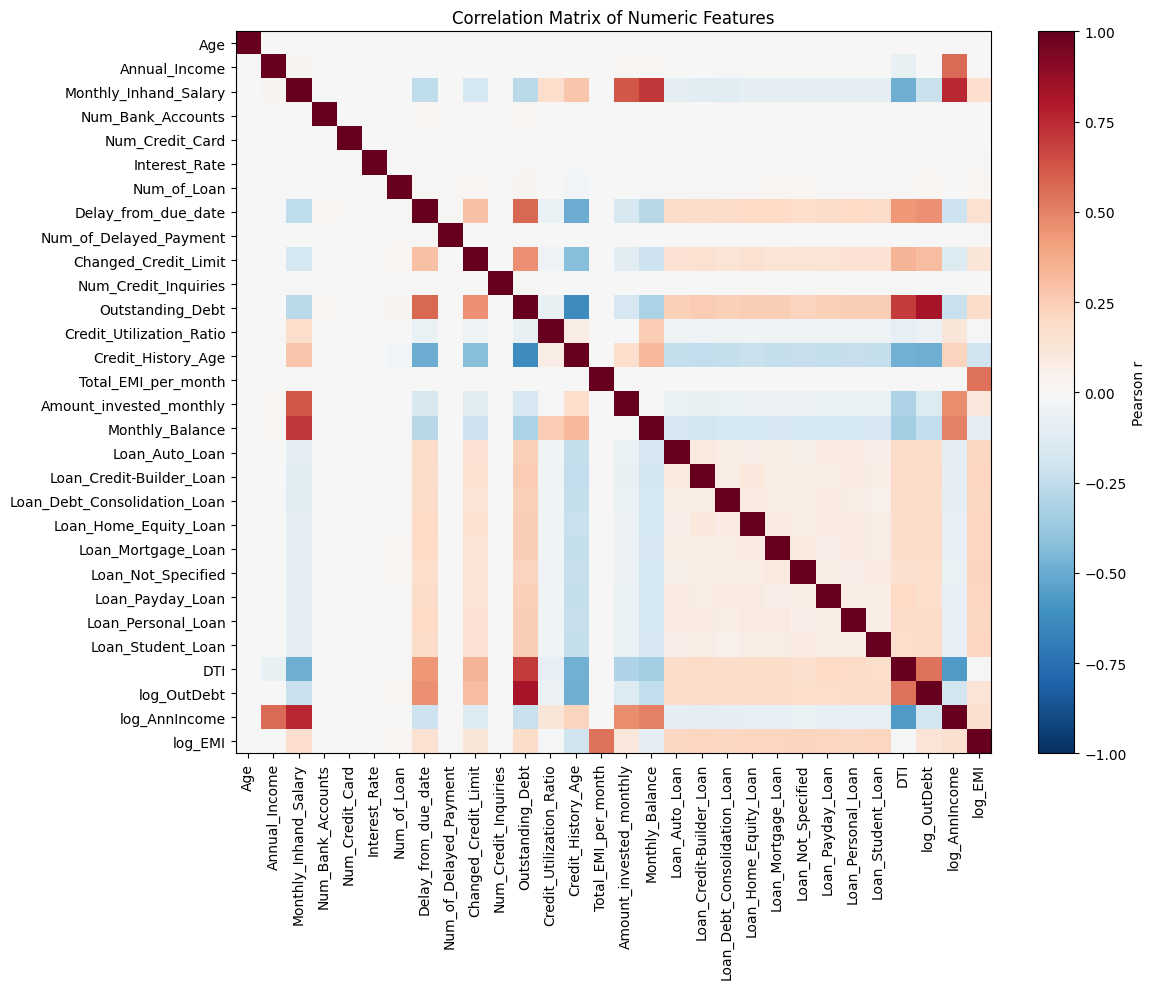

Highly correlated feature pairs (|r| > 0.7):
               feature_1              feature_2      corr
0       Outstanding_Debt            log_OutDebt  0.823493
1  Monthly_Inhand_Salary          log_AnnIncome  0.751941
2        Monthly_Balance  Monthly_Inhand_Salary  0.704899


In [115]:
numeric_cols = dataset.select_dtypes(include=[np.number]).columns

# Compute the Pearson correlation matrix
corr = dataset[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(np.arange(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(np.arange(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

# Extract all unique feature‐pairs with high correlation (in our opinion everything above 0.7 is high)
corr_pairs = (
    corr
      .abs()                         
      .unstack()                     
      .reset_index(name='corr')      
)
corr_pairs.columns = ['feature_1', 'feature_2', 'corr']

# filter out self‐pairs and duplicates (A,B vs B,A)
strong_pairs = (
    corr_pairs[
        (corr_pairs['feature_1'] < corr_pairs['feature_2']) &
        (corr_pairs['corr'] > 0.7)
    ]
    .sort_values('corr', ascending=False)
    .reset_index(drop=True)
)

print("Highly correlated feature pairs (|r| > 0.7):")
print(strong_pairs)

**Short Summary**

Outstanding_Debt and its log‐transform (log_OutDebt) obviously show a very high correlation (r ≈ 0.82).

log_AnnIncome and Monthly_Inhand_Salary correlate at r ≈ 0.75.
 
Monthly_Balance and Monthly_Inhand_Salary correlate at r ≈ 0.70. 

We will adress this threat of multicollinearity later after a data cleaning and a proper data inspection. As of now we will remember all pairs.

By removing one feature from each highly‐correlated pair, we reduce multicollinearity, simplify the model, and ensure that each remaining variable contributes unique information.

# Cleaning and further Analysis

Here we do a first split of our data to have sth on with which we can test our cleaning functions. To avoid any data leakage during the cleaning process, we already divide the dataset here. Additionally, we only develop functions or classes which can be used in pipelines.

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


# Separate features and target
target_col = 'Credit_Score' 
X = dataset.drop(columns=[target_col]).copy()

# Explicit category order
encoder = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])

# Must be 2D input
y = dataset[[target_col]].copy()
y[target_col] = encoder.fit_transform(y[[target_col]]).astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# class distributions
print("Train distribution:\n", y_train.value_counts(normalize=True))
print("Test  distribution:\n", y_test.value_counts(normalize=True))


Train distribution:
 Credit_Score
1               0.531743
0               0.289986
2               0.178271
Name: proportion, dtype: float64
Test  distribution:
 Credit_Score
1               0.531733
0               0.289967
2               0.178300
Name: proportion, dtype: float64


In [117]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 37 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   Month                         100000 non-null  object  
 1   Age                           94974 non-null   float64 
 2   Occupation                    99909 non-null   object  
 3   Annual_Income                 92932 non-null   float64 
 4   Monthly_Inhand_Salary         84920 non-null   float64 
 5   Num_Bank_Accounts             99909 non-null   float64 
 6   Num_Credit_Card               99909 non-null   float64 
 7   Interest_Rate                 99909 non-null   float64 
 8   Num_of_Loan                   95127 non-null   float64 
 9   Delay_from_due_date           100000 non-null  int64   
 10  Num_of_Delayed_Payment        90254 non-null   float64 
 11  Changed_Credit_Limit          97909 non-null   float64 
 12  Num_Credit_Inquiries          9

In [118]:
X.describe()

Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  94974.000000   9.293200e+04           84920.000000       99909.000000   
mean     110.863615   1.784985e+05            4194.071131          17.104395   
std      689.228869   1.443061e+06            3183.605038         117.454091   
min     -500.000000   7.005930e+03             303.645417          -1.000000   
25%       24.000000   1.943628e+04            1625.597917           3.000000   
50%       33.000000   3.755074e+04            3093.745000           6.000000   
75%       42.000000   7.284338e+04            5957.448333           7.000000   
max     8698.000000   2.419806e+07           15204.633333        1798.000000   

       Num_Credit_Card  Interest_Rate   Num_of_Loan  Delay_from_due_date  \
count     99909.000000   99909.000000  95127.000000        100000.000000   
mean         22.495621      72.469027      2.781765            21.068780   
std         129.115463     466.383442     62.528021            14.860104   
min           0.000000       1.000000   -100.000000            -5.000000   
25%           4.000000       8.000000      1.000000            10.000000   
50%           5.000000      13.000000      3.000000            18.000000   
75%           7.000000      20.000000      5.000000            28.000000   
max        1499.000000    5797.000000   1496.000000            67.000000   

       Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries  \
count            90254.000000          97909.000000          98035.000000   
mean                31.027777             10.389025             27.754251   
std                226.956479              6.789496            193.177339   
min                -27.000000             -6.490000              0.000000   
25%                  9.000000              5.320000              3.000000   
50%                 14.000000              9.400000              6.000000   
75%                 18.000000             14.870000              9.000000   
max               4397.000000             36.970000           2597.000000   

       Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
count      98991.000000             100000.000000        90970.000000   
mean        1426.503700                 32.285173          221.195405   
std         1155.045753                  5.116875           99.741364   
min            0.230000                 20.000000            1.000000   
25%          566.080000                 28.052567          144.000000   
50%         1166.370000                 32.305784          219.000000   
75%         1948.200000                 36.496663          302.000000   
max         4998.070000                 50.000000          404.000000   

       Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance  \
count        100000.000000             91216.000000     98791.000000   
mean           1403.118217               195.539456       402.551258   
std            8306.041270               199.564527       213.925499   
min               0.000000                 0.000000         0.007760   
25%              30.306660                72.236692       270.106630   
50%              69.249473               128.954538       336.731225   
75%             161.224249               236.815814       470.262938   
max           82331.000000              1977.326102      1602.040519   

       Loan_Auto_Loan  Loan_Credit-Builder_Loan  Loan_Debt_Consolidation_Loan  \
count   100000.000000             100000.000000                 100000.000000   
mean         0.305300                  0.316980                      0.310120   
std          0.460537                  0.465302                      0.462545   
min          0.000000                  0.000000                      0.000000   
25%          0.000000                  0.000000                      0.000000   
50%          0.000000                  0.000000                      0.000000   
75%          1.000000                  1.0

**Structured Feature Preparation**

This code helps us to organizes our features into three types for tailored preprocessing



In [119]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
ordinal_features = ["Credit_Mix", "Age_Group", "History_Length"]
nominal_features = [col for col in categorical_features if col not in ordinal_features and col not in dummies]
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

credit_mix_order    = ["bad", "standard", "good"]
age_group_order     = ["0-25", "26-35", "36-45",  "51+"]
history_length_order = ["Short", "Medium", "Long"]

ordinal_categories = [
    credit_mix_order,
    age_group_order,
    history_length_order,
]

**Correct month names**

We fixed mistyped month names by finding the closest match among the 12 canonical months;
if a close match (similarity ≥ 0.6) is found, return the standard month name, 
otherwise just capitalize the input for consistency.


In [120]:
def correct_month(month_str):
    # Define the canonical month names.
    canonical_months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]
    # Clean the input string.
    candidate = month_str.strip().lower()
    
    # Find the closest match (using a cutoff for similarity).
    matches = difflib.get_close_matches(candidate, [m.lower() for m in canonical_months], n=1, cutoff=0.6)
    
    if matches:
        # Return the canonical name matching the found close match.
        for m in canonical_months:
            if m.lower() == matches[0]:
                return m
    else:
        # Fallback: return the original string capitalized.
        return month_str.capitalize()

**Business logic limits**

We enforce numeric bounds by replacing any entries below the lower limit or above the upper limit with NaN, ensuring the column contains only values within the defined acceptable range.

In [121]:
def business_logic_limits(df, column, lower_limit, upper_limit):
    # Replace values below the lower limit with NaN
    df[column] = df[column].apply(lambda x: np.nan if x < lower_limit else x)
    
    # Replace values above the upper limit with NaN
    df[column] = df[column].apply(lambda x: np.nan if x > upper_limit else x)
    
    return df


**Handling Outliers with Winsorization**

This function caps extreme values in our data using the IQR method, replacing outliers beyond thresholds with the nearest "normal" value to reduce their impact while keeping most data intact. We use the 95th percentile as an additional safeguard against over-aggressive clipping.

In [122]:
def winsorize_by_iqr(df, column, lower_threshold_factor=3, upper_threshold_factor=3):

    # Calculate the IQR (Interquartile Range)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    p95 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds based on the IQR method
    lower_bound = Q1 - lower_threshold_factor * IQR
    upper_bound = min(p95, Q3 + upper_threshold_factor * IQR)
    
    # Apply winsorization: cap values that are below the lower bound or above the upper bound
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    
    return df

**DataCleaning transformer**

We built a scikit-learn–style estimator that in fit() scans the training data to compute IQR-based winsorization bounds for any numeric fields flagged as having nonsense outliers, and then in transform() applies consistent lowercasing and underscore removal (except for allowed columns), corrects month names, replaces empty occupations with NaN, enforces user-defined business-logic limits, and finally winsorizes values, all using only statistics learned from the training set to avoid any data leakage.

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaning(BaseEstimator, TransformerMixin):
    def __init__(self, cleaning_rules, lower_threshold_factor=3, upper_threshold_factor=3):
        self.cleaning_rules = cleaning_rules
        self.lower_threshold_factor = lower_threshold_factor
        self.upper_threshold_factor = upper_threshold_factor
        self._winsor_bounds = {}
        self.allow_underscore = ['Payment_Behaviour']

    def fit(self, X, y=None):
        self._winsor_bounds = {}
        for variable in X.columns:
            if variable in self.cleaning_rules:
                rule = self.cleaning_rules[variable]
                if rule.get('nonsense_outliers', False):
                    col = X[variable]
                    Q1 = col.quantile(0.25)
                    Q3 = col.quantile(0.75)
                    p95 = col.quantile(0.95)
                    IQR = Q3 - Q1
                    lower = Q1 - self.lower_threshold_factor * IQR
                    upper = min(p95, Q3 + self.upper_threshold_factor * IQR)
                    self._winsor_bounds[variable] = (lower, upper)
        return self

    def transform(self, X):
        cleaned_data = X.copy()
        # Apply underscore removal to all object columns except those in allow_underscore
        for col in cleaned_data.columns:
            if cleaned_data[col].dtype == 'object':
                cleaned_data[col] = cleaned_data[col].astype(str).str.lower()
            if cleaned_data[col].dtype == 'object' and col not in self.allow_underscore:
                cleaned_data[col] = cleaned_data[col].astype(str).str.replace("_", "", regex=False)
            if col == "Month":
                cleaned_data["Month"] = cleaned_data["Month"].apply(correct_month)
            if col == "Occupation":
                cleaned_data["Occupation"] = cleaned_data["Occupation"].replace("", np.nan)
        
        # Then apply other cleaning rules
        for variable in cleaned_data.columns:
            if variable in self.cleaning_rules:
                rule = self.cleaning_rules[variable]
                # Apply business logic limits if needed
                if rule.get("is_numeric", False) and rule.get("business_logic", False):
                    min_val = rule.get("business_logic_min", None)
                    max_val = rule.get("business_logic_max", None)
                    business_logic_limits(cleaned_data, variable, min_val, max_val)
                # Apply winsorization using stored bounds
                if rule.get("nonsense_outliers", False):
                    bounds = self._winsor_bounds.get(variable, None)
                    if bounds is not None:
                        lower, upper = bounds
                        cleaned_data[variable] = cleaned_data[variable].apply(
                            lambda x: lower if x < lower else (upper if x > upper else x)
                        )
        return cleaned_data

**Defining Data Quality Rules**

We created this dictionary to systematically document how each column in our dataset should be cleaned and validated. For every field, we specified:

Basic checks: Whether values should be numeric, unique, or follow business logic (like age being 10-100 or income being positive).

Special handling: Some columns allow value substitutions (like fixing typos in "Occupation").

This acts as a "rulebook" for our cleaning pipeline—both guiding manual checks and enabling automated validation later.

In [124]:
cleaning_rules = {
    "Month": {
        "is_numeric": False,
        "business_logic": True,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Age": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 10,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": True,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Occupation": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": False,
    },
    "Annual_Income": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 10000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "logical_value_substitution": True,
        "sequence_by_step": False,
        "nonsense_outliers": True,
    },
    "Monthly_Inhand_Salary": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Num_Bank_Accounts": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Num_Credit_Card": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Interest_Rate": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Num_of_Loan": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 30,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Type_of_Loan": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Delay_from_due_date": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 365,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Num_of_Delayed_Payment": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Changed_Credit_Limit": {
        "is_numeric": True,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Num_Credit_Inquiries": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": True,
        "nonsense_outliers": True,
    },
    "Credit_Mix": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Outstanding_Debt": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Credit_Utilization_Ratio": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0.0,
        "business_logic_max": 100,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Credit_History_Age": {
        "is_numeric": True,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_value_filling": None,
        "single_change": False,
        "sequence_by_step": True,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Payment_of_Min_Amount": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Total_EMI_per_month": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 200000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Amount_invested_monthly": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 100000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Payment_Behaviour": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    },
    "Monthly_Balance": {
        "is_numeric": True,
        "business_logic": True,
        "business_logic_min": 0,
        "business_logic_max": 1000000,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": True,
    },
    "Credit_Score": {
        "is_numeric": False,
        "business_logic": False,
        "all_values_unique": False,
        "single_value_per_customer": False,
        "single_change": False,
        "sequence_by_step": False,
        "logical_value_substitution": False,
        "nonsense_outliers": False,
    }
}


In [125]:
X_train_copy = X_train.copy()
X_train_copy.head()

Month   Age    Occupation  Annual_Income  Monthly_Inhand_Salary  \
20302   July  22.0    Journalist       19386.02            1858.501667   
54150   July   NaN    Journalist      162590.56           13535.213333   
27701   June  45.0        Lawyer            NaN            1253.378333   
15179  April  31.0  Entrepreneur       59050.48            5018.873333   
35630   July   NaN  Entrepreneur       93390.44            7538.536667   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
20302                4.0              4.0            7.0          3.0   
54150                5.0              6.0           11.0          0.0   
27701                3.0              4.0           13.0          1.0   
15179                8.0              8.0           28.0          9.0   
35630                6.0              5.0           18.0          3.0   

       Delay_from_due_date  Num_of_Delayed_Payment  Changed_Credit_Limit  \
20302                    5                    15.0                  9.74   
54150                   25                     6.0                 11.65   
27701                    9                    11.0                 11.84   
15179                   56                    22.0                 19.29   
35630                   29                    12.0                 11.28   

       Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  \
20302                  11.0          _           2438.26   
54150                   4.0       Good           1000.11   
27701                   0.0          _            927.98   
15179                  10.0        Bad           4283.98   
35630                   0.0   Standard           1036.26   

       Credit_Utilization_Ratio  Credit_History_Age Payment_of_Min_Amount  \
20302                 33.977238               179.0                   Yes   
54150                 29.354953                 NaN                    No   
27701                 31.342164               338.0                   Yes   
15179                 30.657677                26.0                   Yes   
35630                 28.404034                 NaN                    No   

       Total_EMI_per_month  Amount_invested_monthly  \
20302            40.009251               138.276380   
54150             0.000000               617.724289   
27701            12.567581               109.047020   
15179           339.495329               110.415542   
35630           117.487162               758.409188   

                      Payment_Behaviour  Monthly_Balance  Loan_Auto_Loan  \
20302    Low_spent_Small_value_payments       297.564536               0   
54150   Low_spent_Medium_value_payments      1015.797045               0   
27701    Low_spent_Small_value_payments       293.723233               0   
15179  High_spent_Medium_value_payments       301.976463               0   
35630    Low_spent_Small_value_payments       167.957317               0   

       Loan_Credit-Builder_Loan  Loan_Debt_Consolidation_Loan  \
20302                         1                             0   
54150                         0                             0   
27701                         1                             0   
15179                         0                             0   
35630                         0                             1   

       Loan_Home_Equity_Loan  Loan_Mortgage_Loan  Loan_Not_Specified  \
20302                      0                   0                   0   
54150                      0                   0                   0   
27701                      0                   0                   0   
15179                      1                   1                   1   
35630                      0                   0                   0   

       Loan_Payday_Loan  Loan_Personal_Loan  Loan_Student_Loan       DTI  \
20302                 1                   0                  1  0.125774   
54150                 0                   0                  0  0.006151   
27

**Exploring Our Cleaned Data**

After applying our cleaning rules, we visualized each variable to spot any remaining issues and understand distributions.

For numeric variables, we created side-by-side plots:

A density plot showing the distribution shape with mean and percentile markers

A boxplot to highlight outliers
We included key stats like unique/missing values in the title

For categorical data, we made two types of charts:

Simple bar plots for variables with ≤20 categories

"Top 19 + Other" grouped plots for high-cardinality fields

Dummy variables got special treatment with binary percentage bars to show class balance.

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


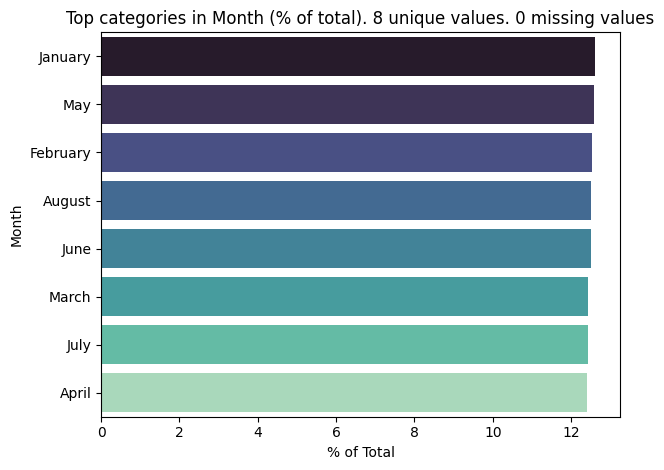

count    64562.000000
mean        33.229516
std         10.677681
min         14.000000
50%         33.000000
95%         52.000000
99%         53.000000
max         53.000000
Name: Age, dtype: float64


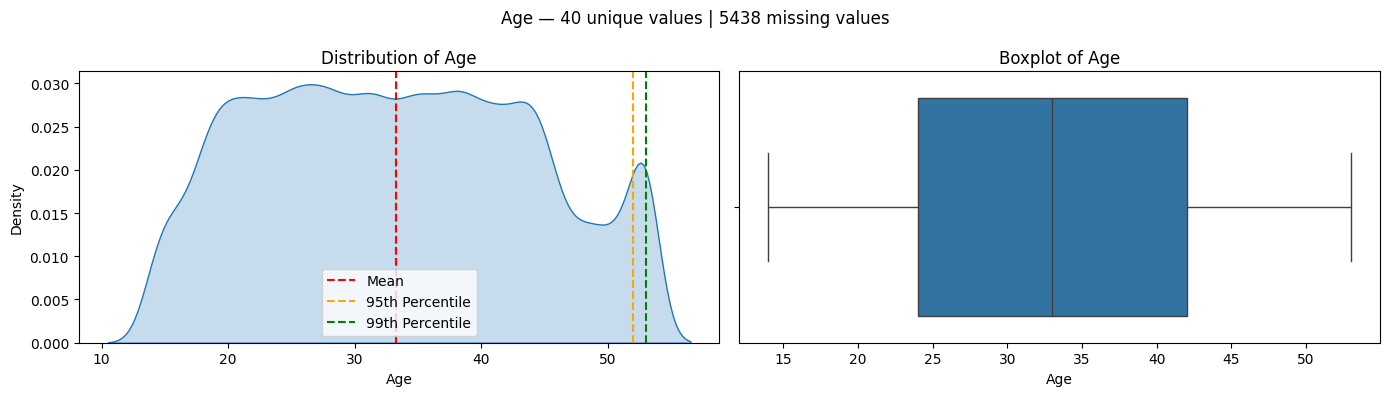

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


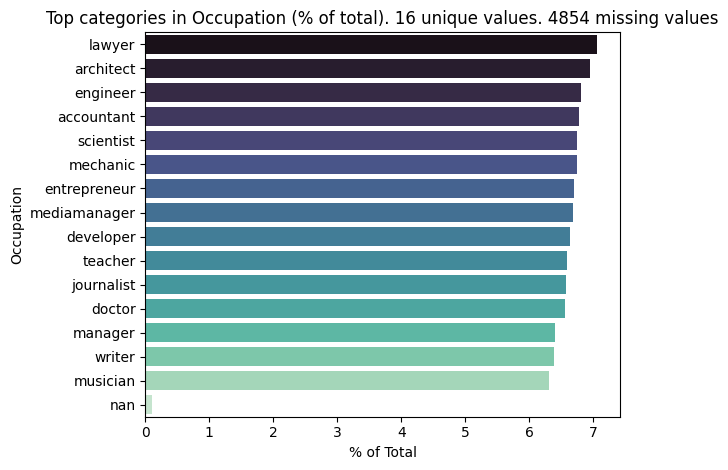

count     64631.000000
mean      49994.112037
std       36605.126779
min        7005.930000
50%       37045.780000
95%      131990.840000
99%      134734.160000
max      134734.160000
Name: Annual_Income, dtype: float64


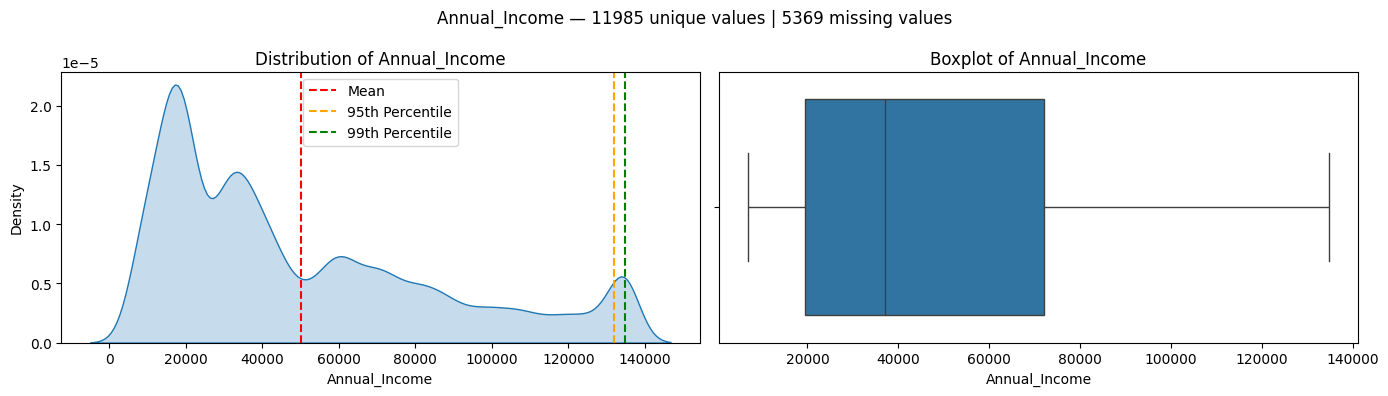

count    59469.000000
mean      4109.217890
std       2979.938825
min        303.645417
50%       3084.106667
95%      10841.770267
99%      10841.832667
max      10841.832667
Name: Monthly_Inhand_Salary, dtype: float64


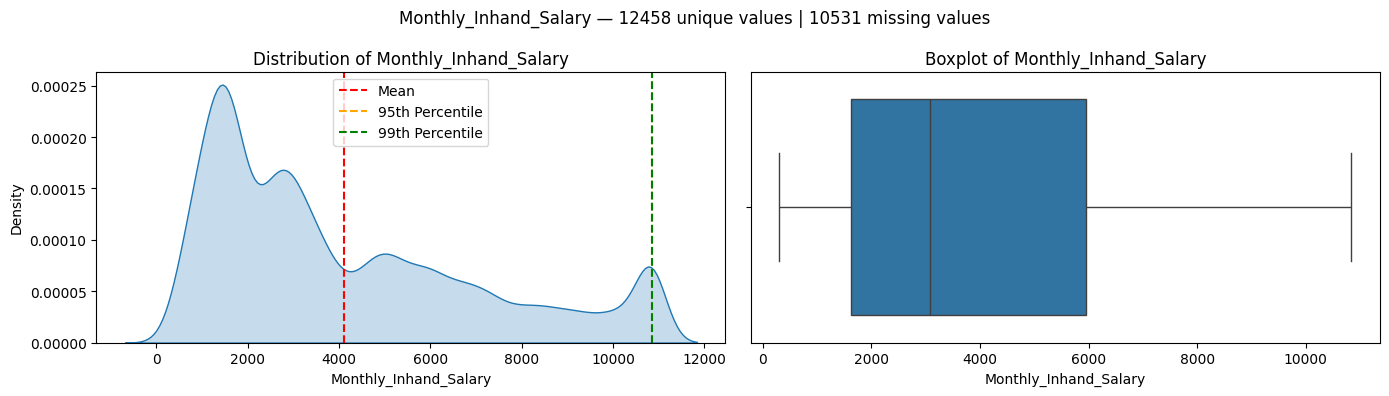

count    68986.000000
mean         5.371583
std          2.588731
min          0.000000
50%          5.000000
95%         10.000000
99%         10.000000
max         10.000000
Name: Num_Bank_Accounts, dtype: float64


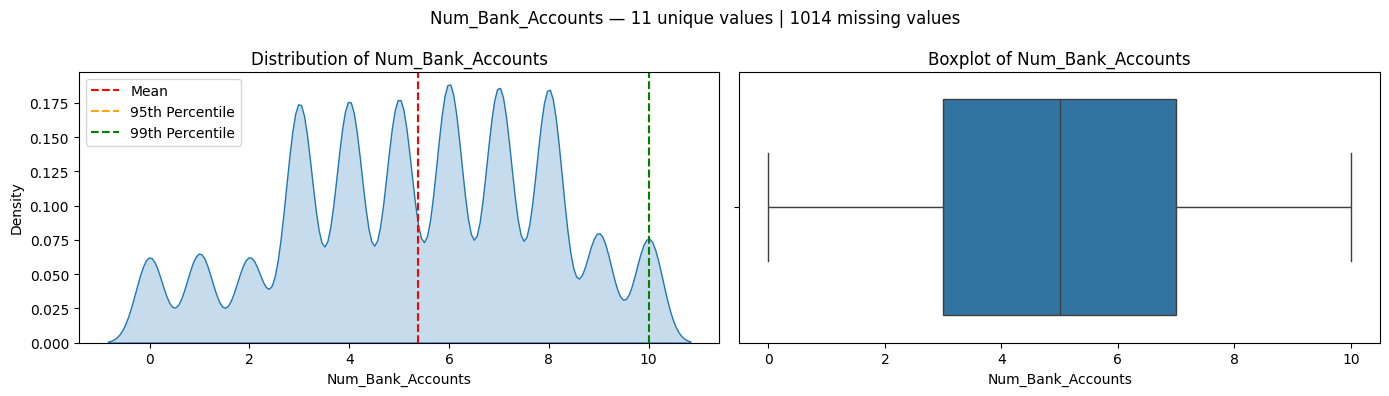

count    68373.000000
mean         5.534275
std          2.067581
min          0.000000
50%          5.000000
95%         10.000000
99%         10.000000
max         10.000000
Name: Num_Credit_Card, dtype: float64


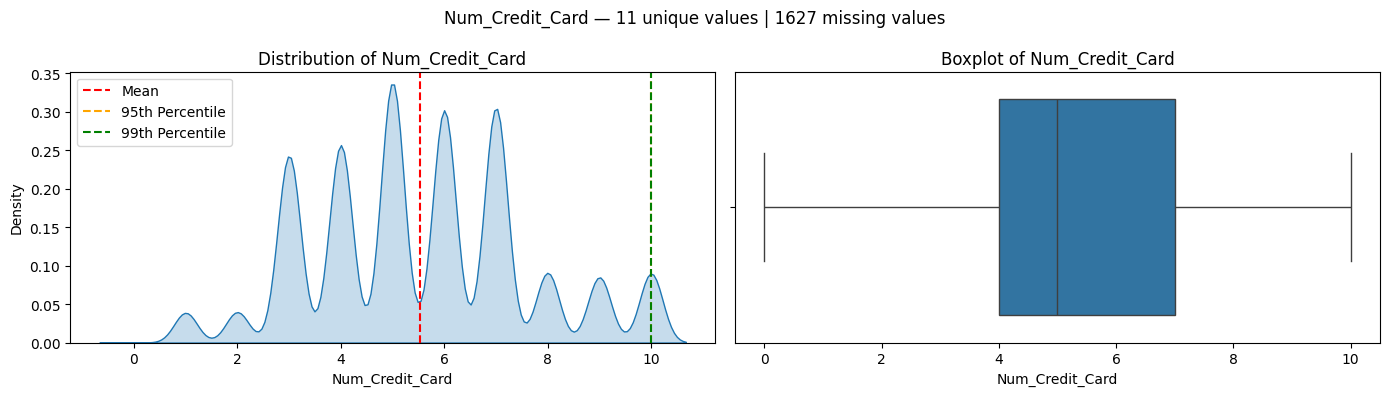

count    68521.000000
mean        14.489850
std          8.642414
min          1.000000
50%         13.000000
95%         31.000000
99%         32.000000
max         32.000000
Name: Interest_Rate, dtype: float64


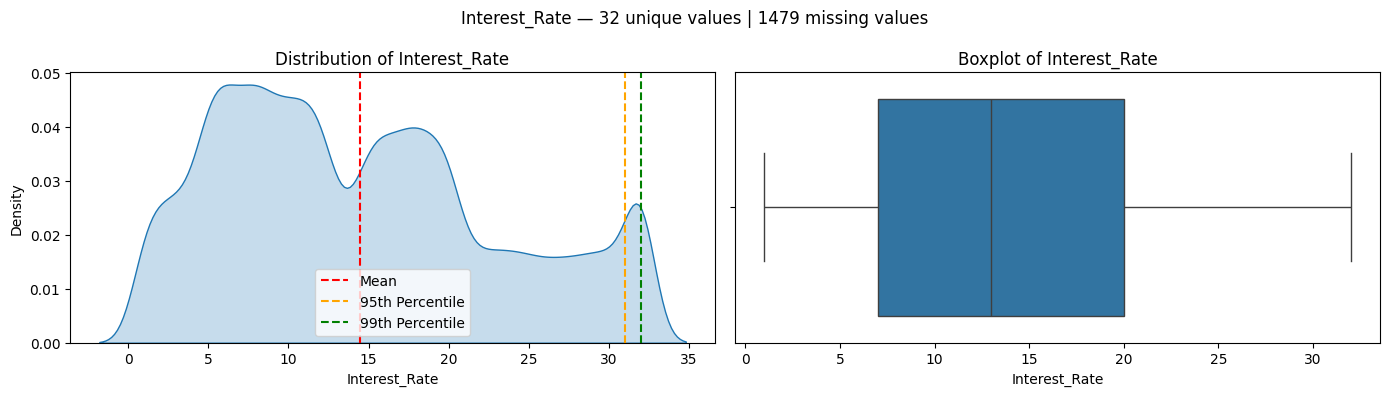

count    63623.000000
mean         3.502743
std          2.366419
min          0.000000
50%          3.000000
95%          8.000000
99%          8.000000
max          8.000000
Name: Num_of_Loan, dtype: float64


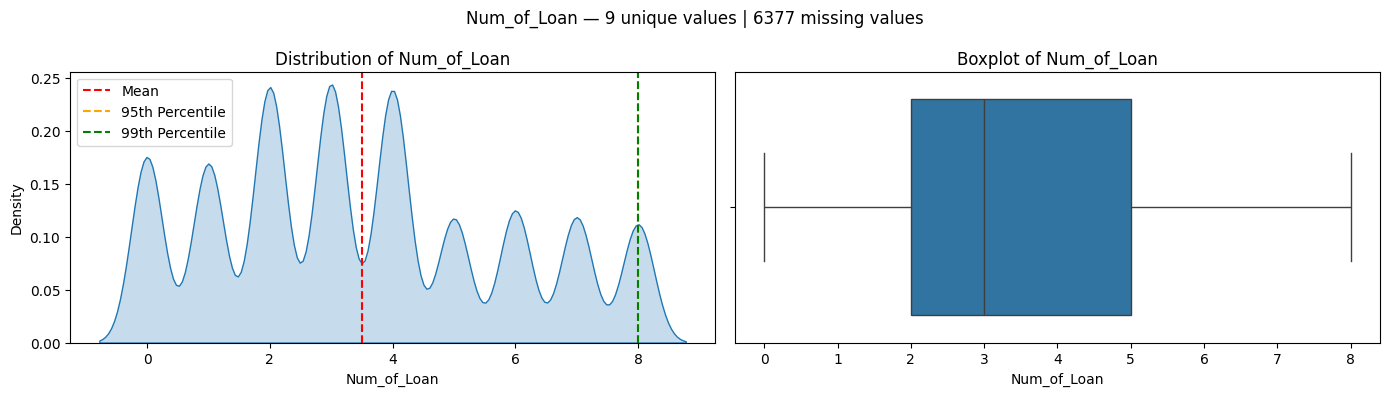

count    69574.000000
mean        21.004729
std         14.253455
min          0.000000
50%         18.000000
95%         54.000000
99%         54.000000
max         54.000000
Name: Delay_from_due_date, dtype: float64


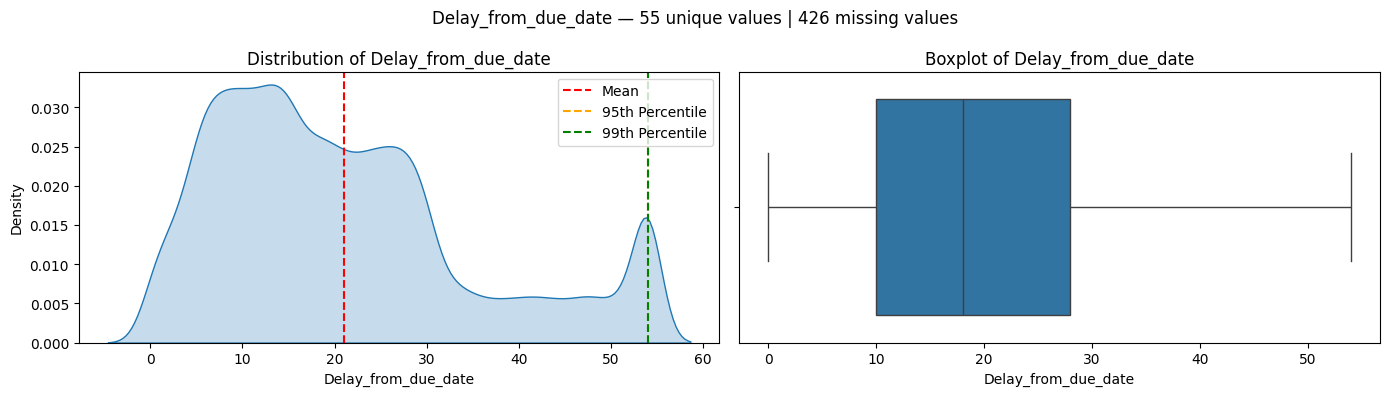

count    62239.000000
mean        13.413953
std          6.135682
min          0.000000
50%         14.000000
95%         23.000000
99%         24.000000
max         24.000000
Name: Num_of_Delayed_Payment, dtype: float64


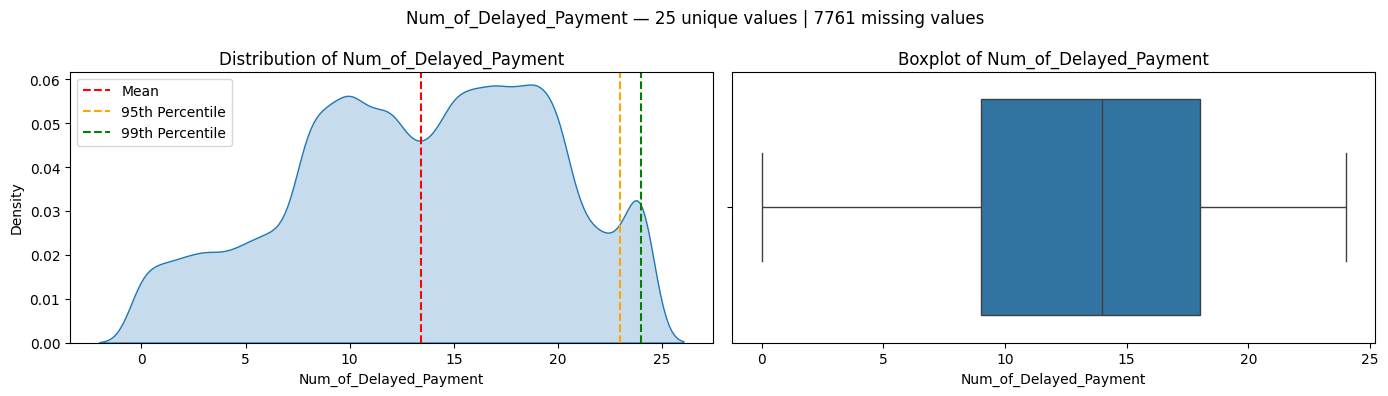

count    68500.000000
mean        10.390668
std          6.795325
min         -6.490000
50%          9.400000
95%         23.670500
99%         28.830000
max         36.970000
Name: Changed_Credit_Limit, dtype: float64


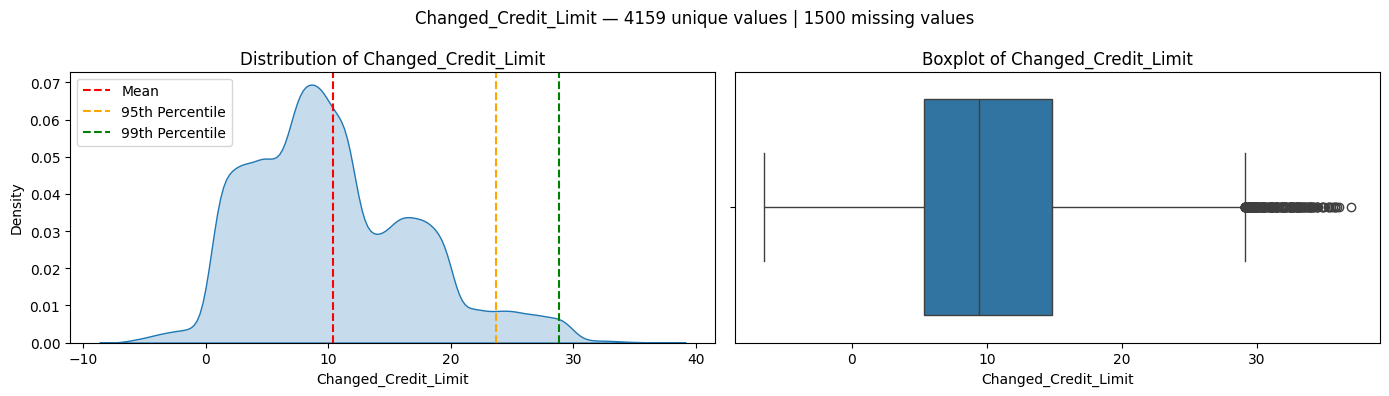

count    67497.000000
mean         5.734003
std          3.741955
min          0.000000
50%          5.000000
95%         12.000000
99%         13.000000
max         13.000000
Name: Num_Credit_Inquiries, dtype: float64


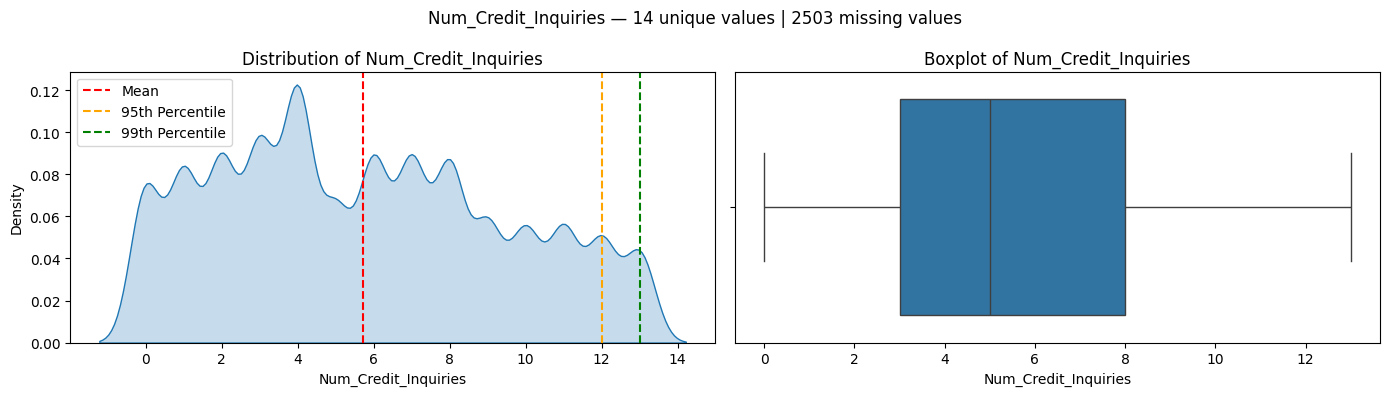

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


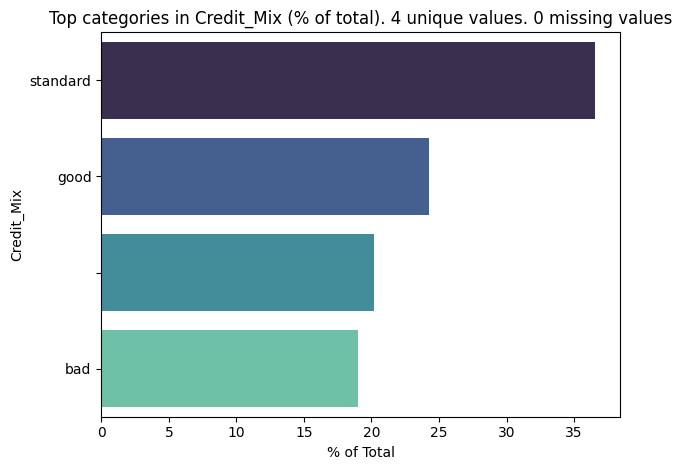

count    69299.000000
mean      1428.165649
std       1156.567299
min          0.230000
50%       1166.910000
95%       4085.140000
99%       4801.094800
max       4998.070000
Name: Outstanding_Debt, dtype: float64


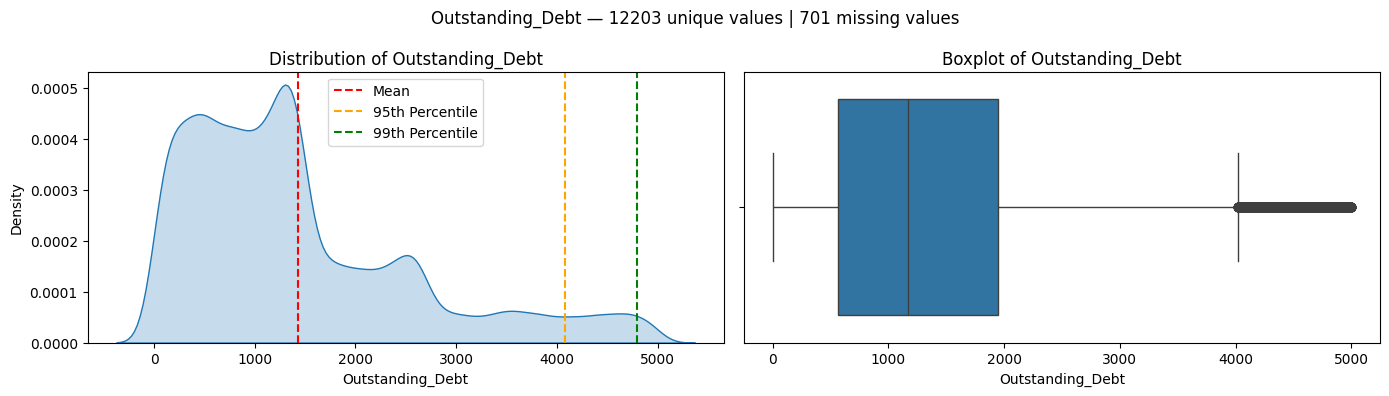

count    70000.000000
mean        32.274543
std          5.118649
min         20.000000
50%         32.298463
95%         40.209639
99%         42.449940
max         50.000000
Name: Credit_Utilization_Ratio, dtype: float64


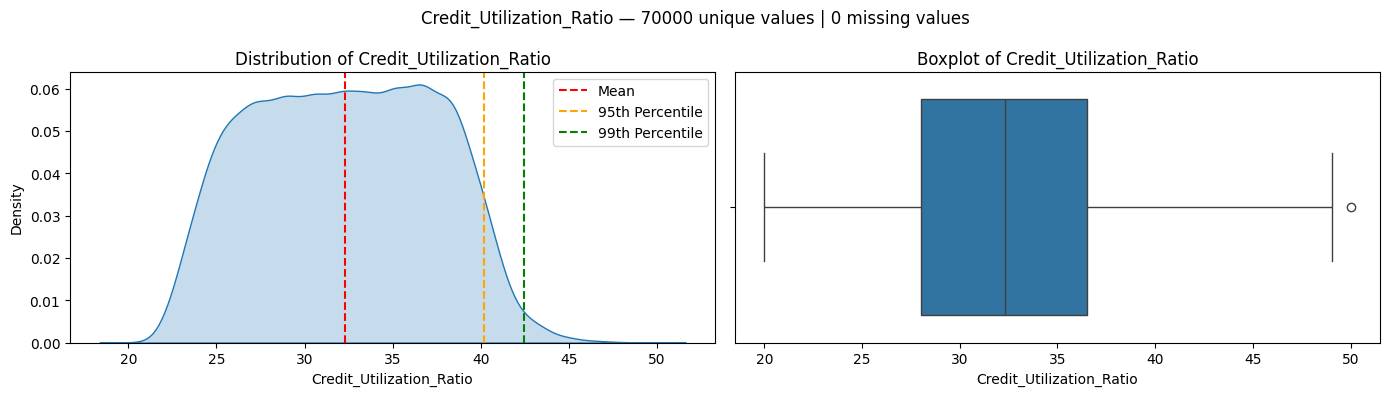

count    63663.000000
mean       221.245150
std         99.807095
min          1.000000
50%        220.000000
95%        382.000000
99%        396.000000
max        404.000000
Name: Credit_History_Age, dtype: float64


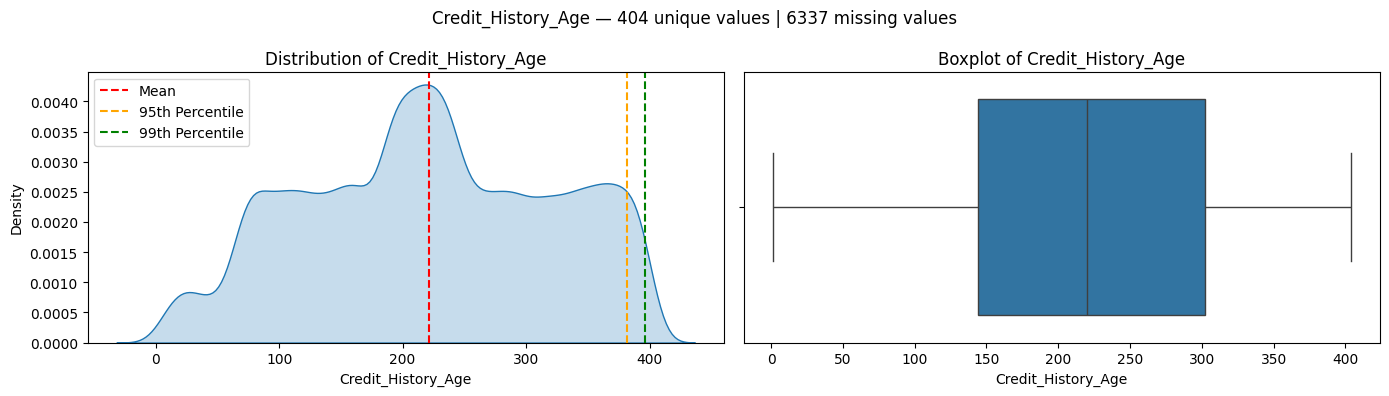

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


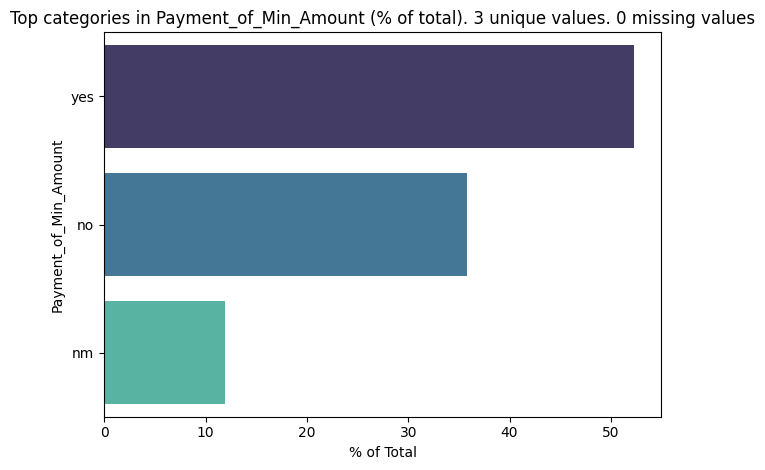

count    70000.000000
mean       112.354169
std        115.551289
min          0.000000
50%         69.055656
95%        432.521330
99%        432.521541
max        432.521541
Name: Total_EMI_per_month, dtype: float64


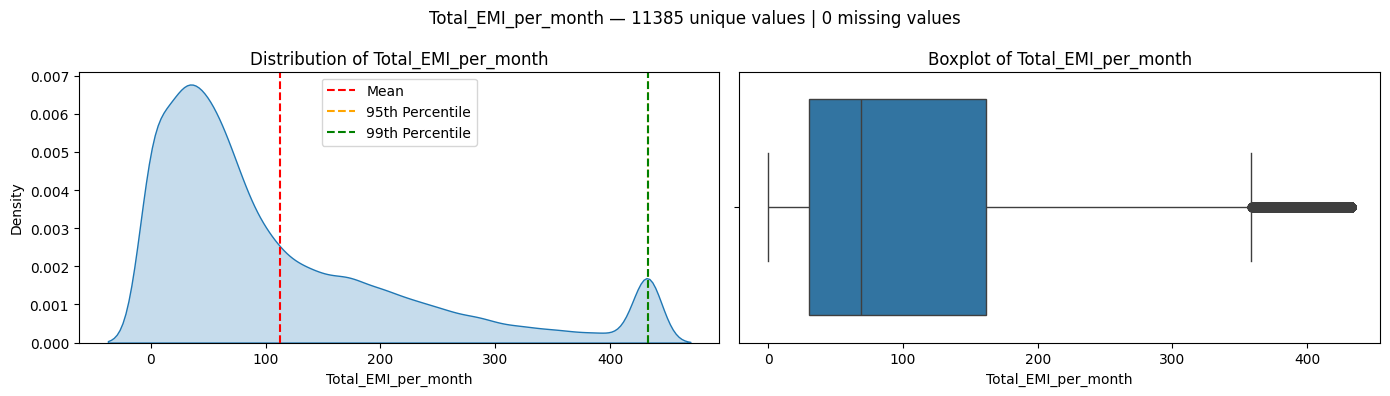

count    63855.000000
mean       183.995639
std        157.817712
min          0.000000
50%        128.952103
95%        612.918247
99%        612.959222
max        612.959222
Name: Amount_invested_monthly, dtype: float64


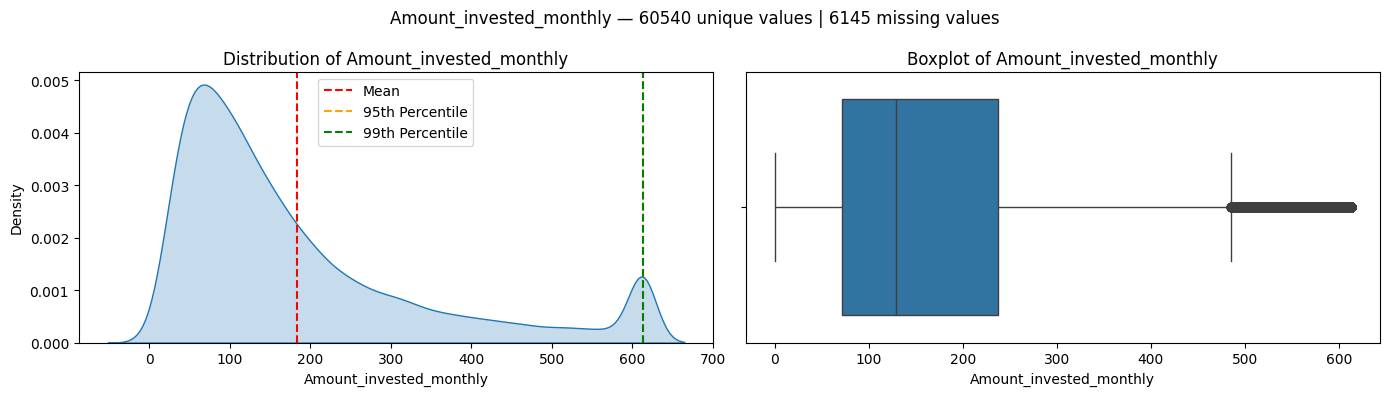

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


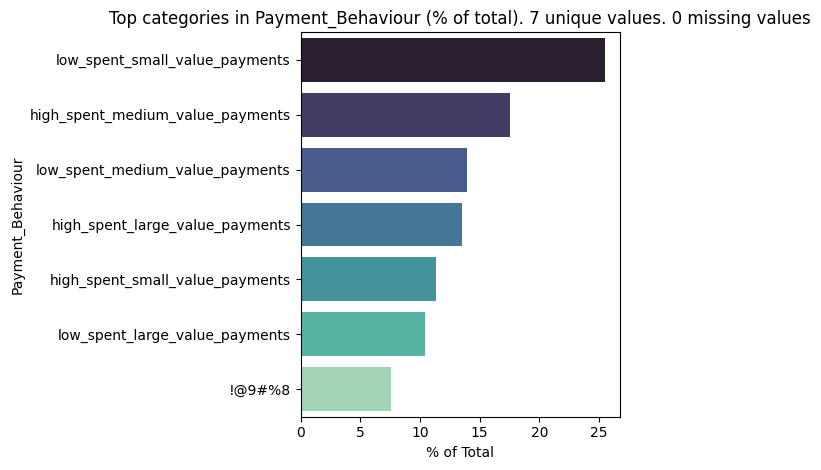

count    69150.000000
mean       393.442824
std        187.767200
min          0.088628
50%        336.419980
95%        859.627208
99%        859.628814
max        859.628814
Name: Monthly_Balance, dtype: float64


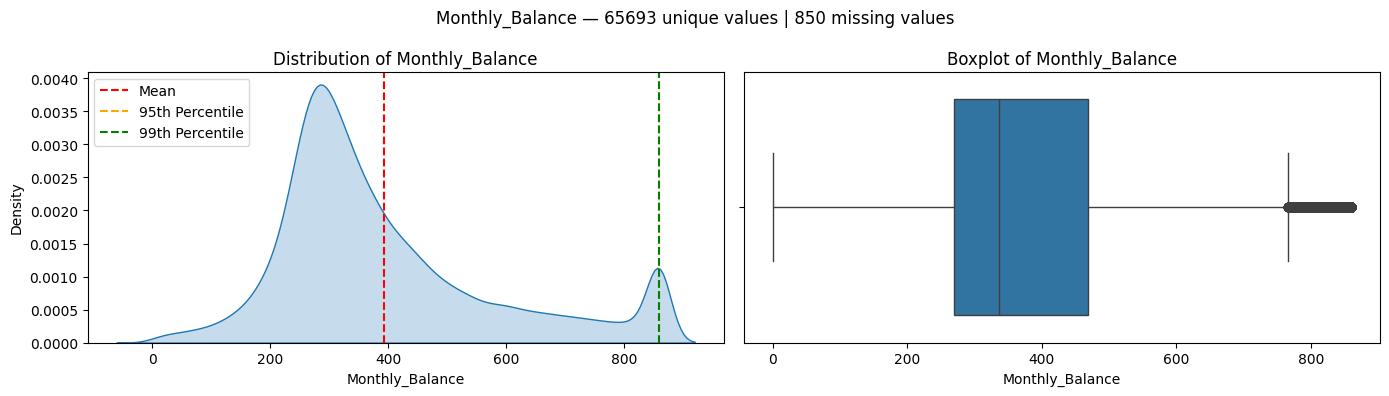

count    70000.000000
mean         0.305486
std          0.460616
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Auto_Loan, dtype: float64


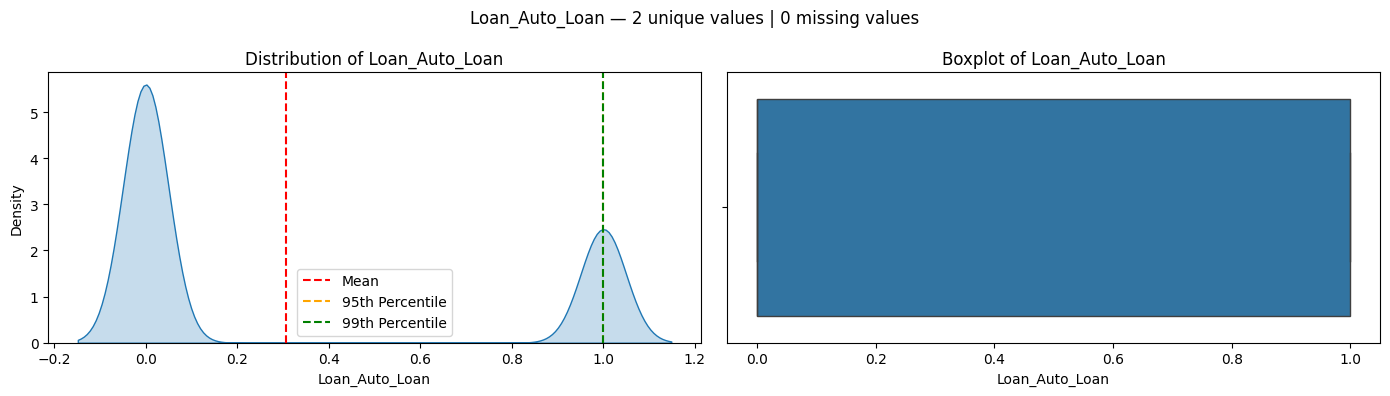

count    70000.000000
mean         0.316714
std          0.465198
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Credit-Builder_Loan, dtype: float64


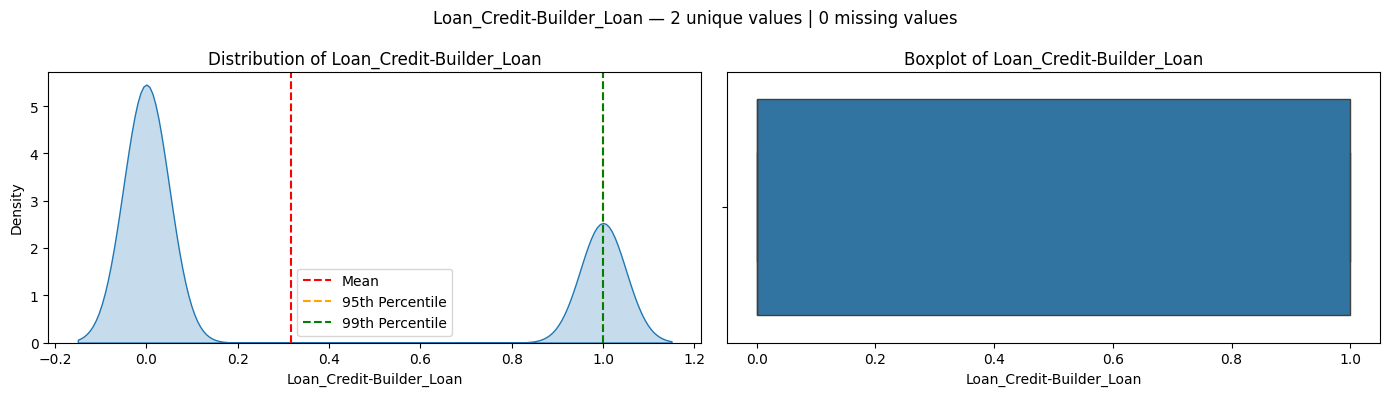

count    70000.000000
mean         0.310814
std          0.462830
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Debt_Consolidation_Loan, dtype: float64


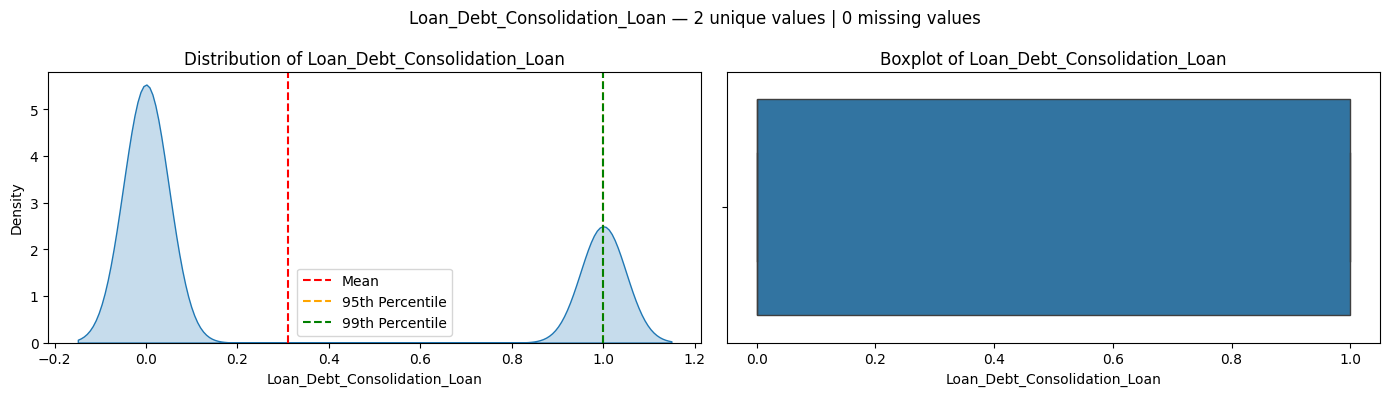

count    70000.000000
mean         0.313886
std          0.464074
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Home_Equity_Loan, dtype: float64


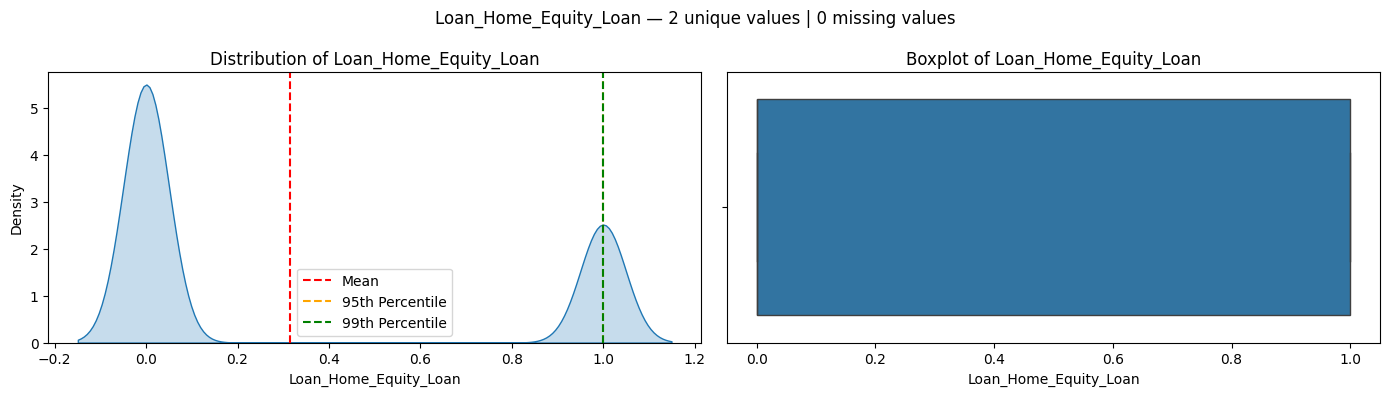

count    70000.000000
mean         0.314371
std          0.464268
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Mortgage_Loan, dtype: float64


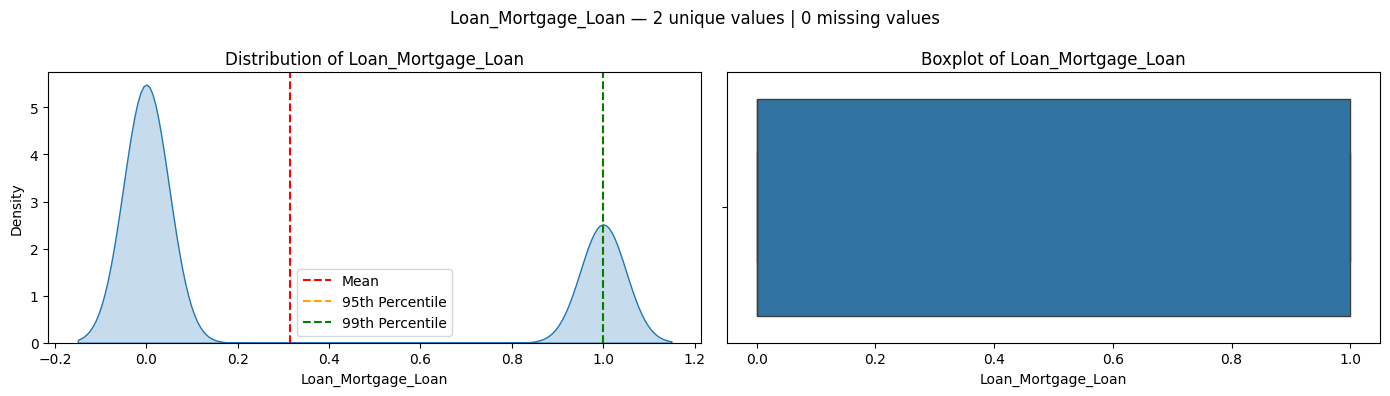

count    70000.000000
mean         0.316414
std          0.465080
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Not_Specified, dtype: float64


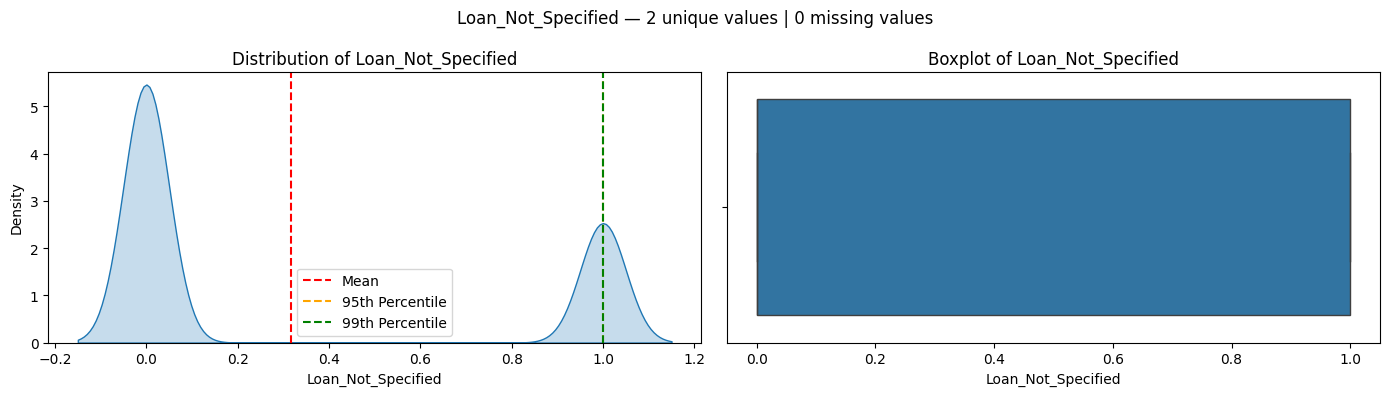

count    70000.000000
mean         0.318929
std          0.466065
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Payday_Loan, dtype: float64


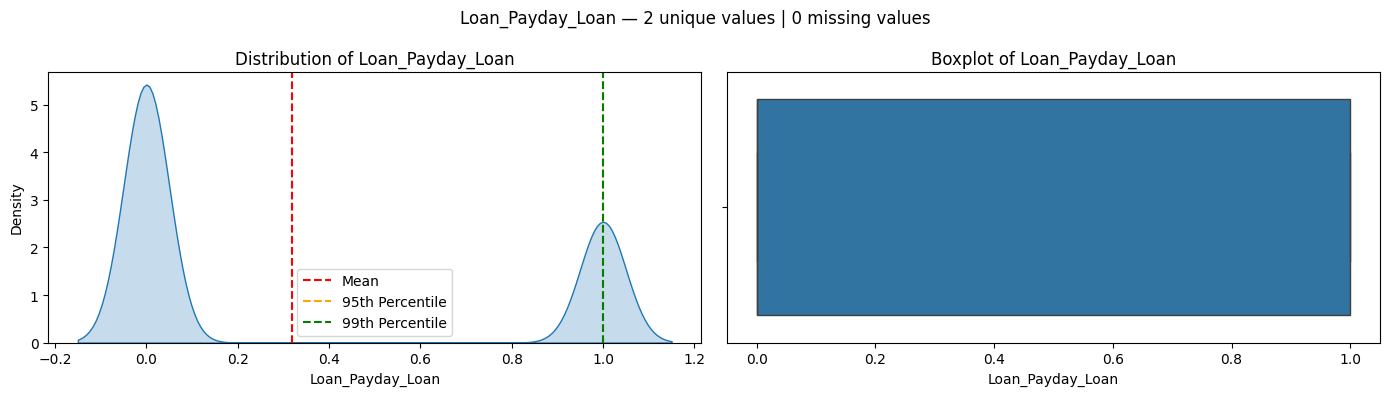

count    70000.000000
mean         0.312329
std          0.463446
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Personal_Loan, dtype: float64


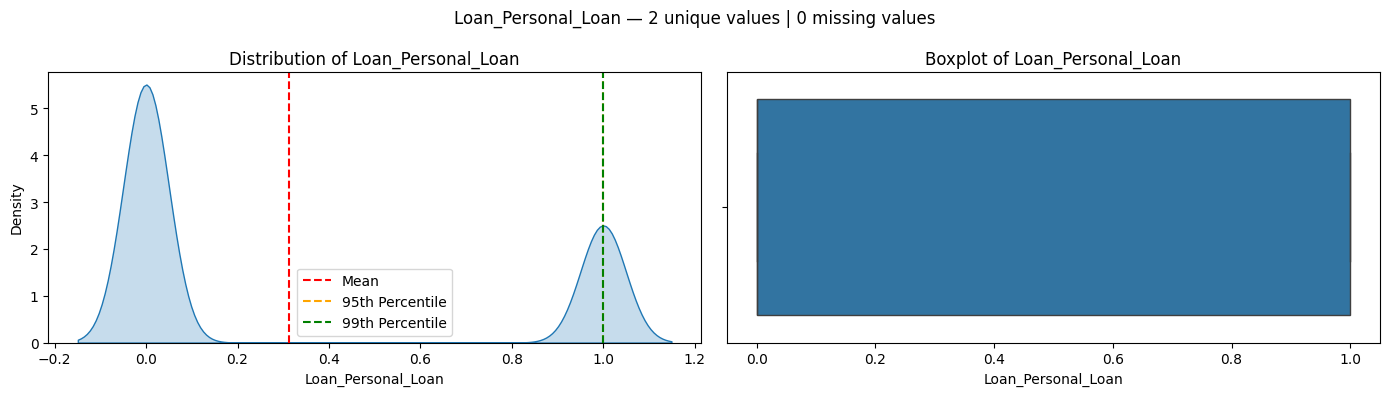

count    70000.000000
mean         0.309443
std          0.462267
min          0.000000
50%          0.000000
95%          1.000000
99%          1.000000
max          1.000000
Name: Loan_Student_Loan, dtype: float64


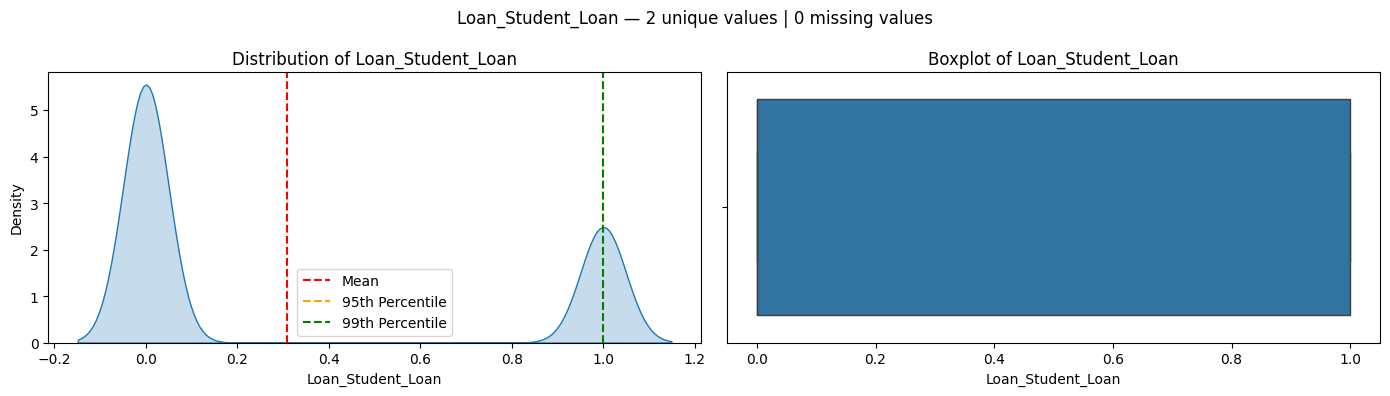

count    6.439000e+04
mean     6.040445e-02
std      8.783368e-02
min      4.086800e-07
50%      2.780409e-02
95%      2.451712e-01
99%      4.523711e-01
max      6.832516e-01
Name: DTI, dtype: float64


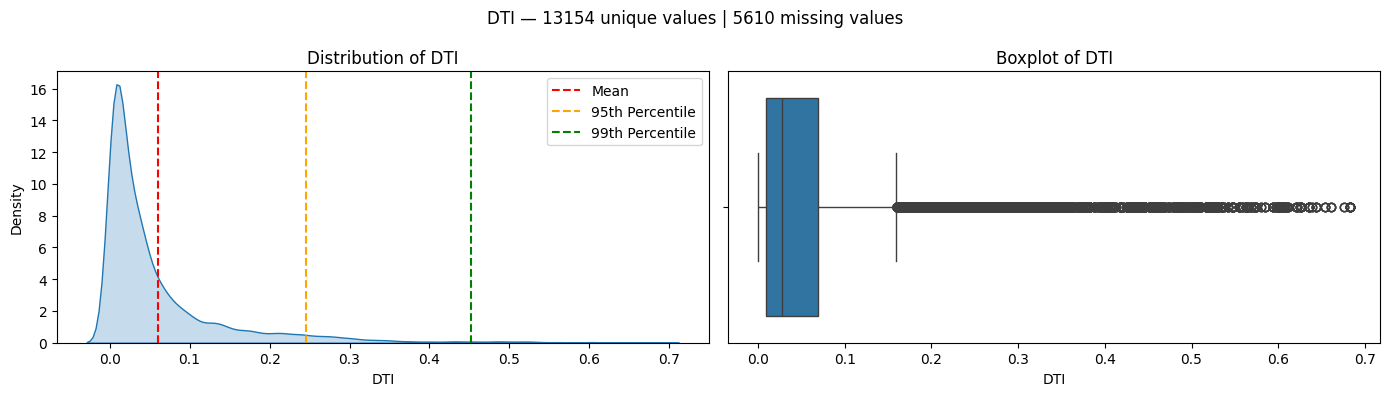

count    69299.000000
mean         6.851157
std          1.079912
min          0.207014
50%          7.062971
95%          8.315356
99%          8.476808
max          8.517007
Name: log_OutDebt, dtype: float64


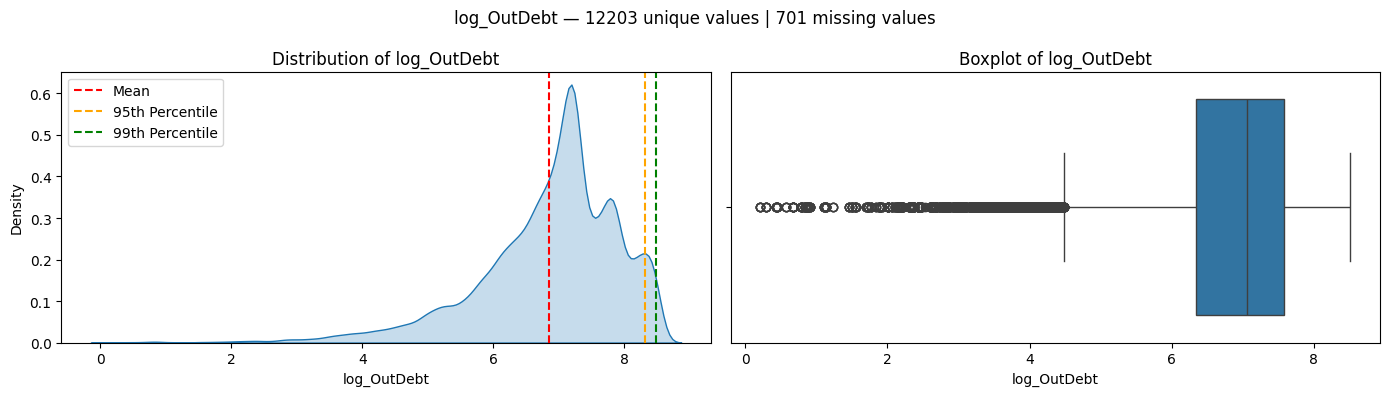

count    65038.000000
mean        10.589865
std          0.967549
min          8.854655
50%         10.530858
95%         11.811066
99%         12.886186
max         17.001783
Name: log_AnnIncome, dtype: float64


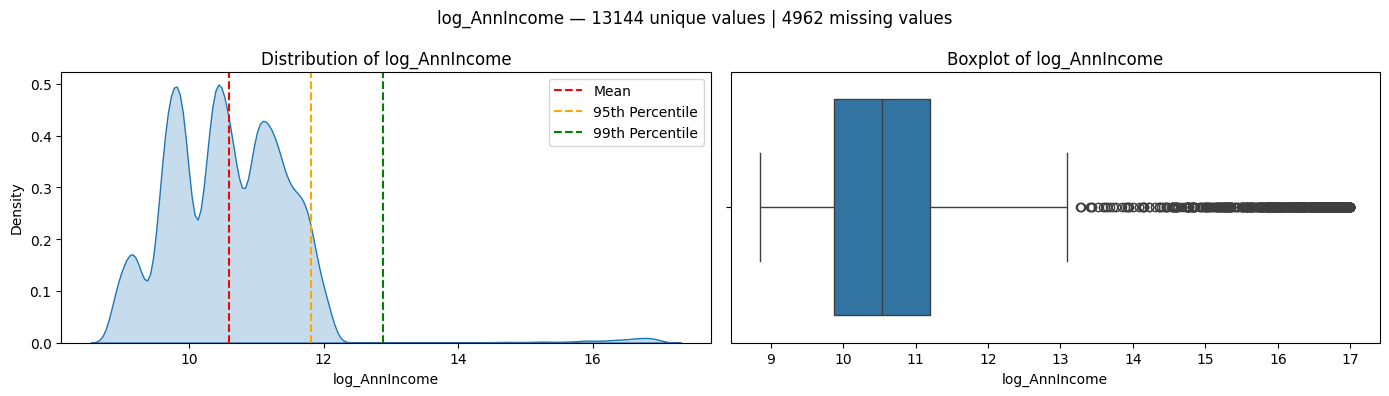

count    70000.000000
mean         4.101964
std          1.956774
min          0.000000
50%          4.249290
95%          6.071941
99%         10.917599
max         11.317604
Name: log_EMI, dtype: float64


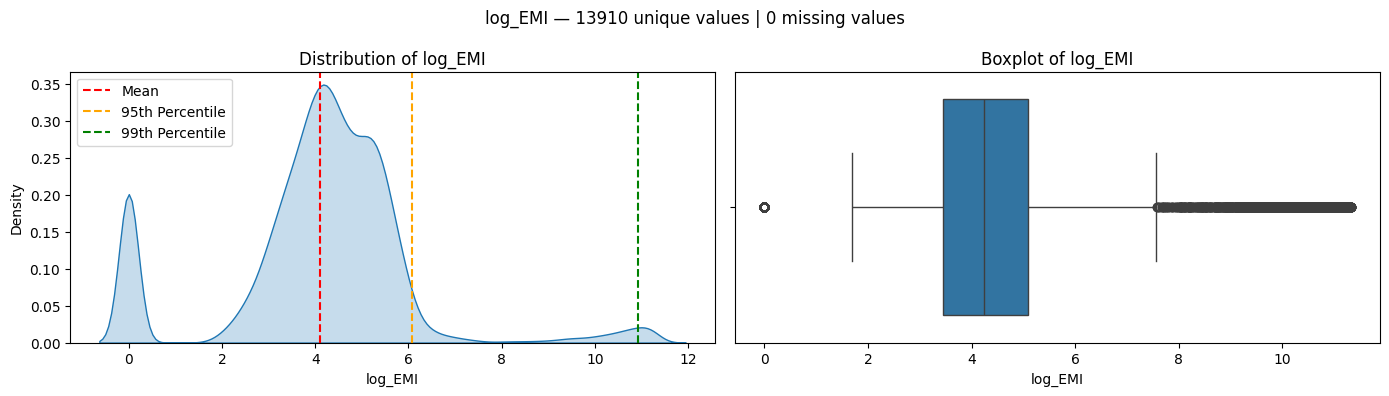

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


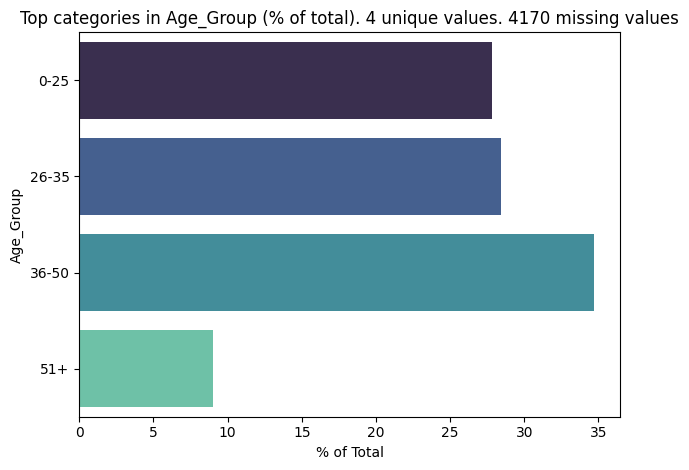

/var/folders/68/7w1qp8xs3b90k8m8trbrtb280000gn/T/ipykernel_10770/628664173.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')


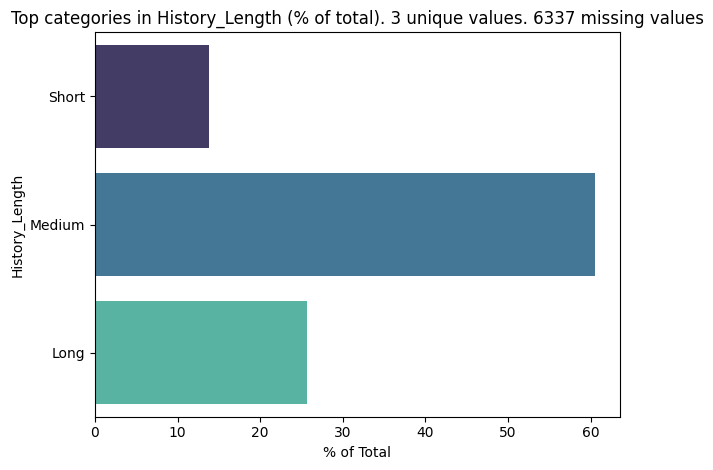

In [126]:

X_train_copy = X_train.copy()
data_to_visualize = DataCleaning(cleaning_rules).fit_transform(X_train_copy)

for variable in data_to_visualize.columns:

    num_unique = data_to_visualize[variable].nunique()
    num_missing = data_to_visualize[variable].isnull().sum()

    if data_to_visualize[variable].dtype in ['float64', 'int64'] and variable not in dummies:
        summary_stats = data_to_visualize[variable].describe(percentiles=[0.95, 0.99]).transpose()
        print(summary_stats)
        mean = summary_stats['mean']
        p95 = summary_stats['95%']
        p99 = summary_stats['99%']

        fig, axes = plt.subplots(1, 2, figsize=(14, 4))

        sns.kdeplot(data=data_to_visualize, x=variable, ax=axes[0], fill=True)
        axes[0].axvline(mean, color='red', linestyle='--', label='Mean')
        axes[0].axvline(p95, color='orange', linestyle='--', label='95th Percentile')
        axes[0].axvline(p99, color='green', linestyle='--', label='99th Percentile')
        axes[0].set_title(f'Distribution of {variable}')
        axes[0].set_xlabel(variable)
        axes[0].set_ylabel('Density')
        axes[0].legend()

        # Boxplot
        sns.boxplot(data=data_to_visualize, x=variable, ax=axes[1], orient='h')
        axes[1].set_title(f'Boxplot of {variable}')
        axes[1].set_xlabel(variable)

        fig.suptitle(f'{variable} — {num_unique} unique values | {num_missing} missing values', fontsize=12)
        plt.tight_layout()
        plt.show()



    elif variable in dummies:
        # Calculate percentage distribution
        value_counts = data_to_visualize[variable].value_counts(normalize=True) * 100

        # Ensure both 0 and 1 are present in the index
        value_counts = value_counts.reindex([0, 1], fill_value=0)

        # Create the plot
        plt.figure(figsize=(8, 4))
        sns.barplot(x=[0, 1], y=value_counts.values, palette='mako')

        # Customize the plot
        plt.title(f'Distribution of {variable} (Dummy Variable)')
        plt.xlabel(variable)
        plt.ylabel('Percentage (%)')

        # Add percentage labels on top of bars
        for i, v in enumerate(value_counts.values):
            plt.text(i, v + 1, f'{v:.1f}%', ha='center')

        plt.xticks([0, 1], ['0', '1']) 

        plt.tight_layout()
        plt.show()


    elif data_to_visualize[variable].dtype not in ['float64', 'int64'] and data_to_visualize[variable].nunique() <= 20:
        value_counts = data_to_visualize[variable].dropna().value_counts(normalize=True) * 100
        sns.barplot(x=value_counts.values, y=value_counts.index, palette='mako')
        plt.title(f'Top categories in {variable} (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

    elif data_to_visualize[variable].dtype not in ['float64', 'int64']:
        # Calculate percentage distribution for all categories
        value_counts = data_to_visualize[variable].dropna().value_counts(normalize=True) * 100
        top_19 = value_counts.head(19)
        other = value_counts[19:].sum()
        value_counts_plot = pd.concat([top_19, pd.Series({'Other': other})])

        sns.barplot(x=value_counts_plot.values, y=value_counts_plot.index, palette='viridis')
        plt.title(f'Top categories in {variable} (Others grouped) (% of total). {num_unique} unique values. {num_missing} missing values')
        plt.xlabel('% of Total')
        plt.ylabel(variable)
        plt.tight_layout()
        plt.show()

    


**Understanding Our Financial Variables**

The plots show that variables like income, debt, and salary aren't perfectly normally distributed, but as that's actually expected in real-world financial data there is no issue here.

The long right tails (eg Annual_Income ) reflect reality: most people cluster around average incomes, while a smaller number earn significantly more.

The 99th percentiles are much higher than the means, confirming this skew.

Outstanding Debt

Shows a similar pattern where most debts are moderate, but some borrowers owe substantially more.

Missing Values Note

Monthly_Inhand_Salary has ≈10k missing entries (more than others) - as this is substantial and on top of that monthly inhand salary is strongly correlated with Annual Income and Montly Salary, wed decided to drop it

Overall, the distribution matches how money-related variables typically behave: unequal distributions with natural extremes.

# Modelling

Scoring Metrics Consideration

1. **Accuracy**: Measures the percentage of correct predictions (TP + TN) over all cases, but can be misleading if classes are imbalanced.
2. **Precision and Recall (per class)**: Useful when you want to minimize false positives and false negatives, respectively.
   - **Precision (good)**: Important if approving a risky (“bad”) loan as “good” carries high cost.
   - **Recall (bad)**: Crucial if failing to identify bad loans results in severe financial losses.
3. **F1-Score**: Harmonic mean of precision and recall. We’ll report macro-F1 to give equal weight to each class in the presence of imbalance.
4. **Area Under the ROC Curve (AUC-ROC)**: Measures class separability across all thresholds (using one-vs-rest in multi-class). A higher AUC indicates better overall discrimination.

Given the importance of both correctly flagging high-risk (“bad”) loans and reliably approving low-risk (“good”) ones F1-score (macro-F1) is likely the most appropriate metric.

**Hyperparameter selection Rationale**
1. Logistic Regression
C (Regularization): Tested [0.01, 10] to balance overfitting (low C) and underfitting (high C).

Penalty: Included both L1 (sparsity) and L2 (stability) to assess which suits our imbalanced data better.

Solver: Restricted to liblinear for compatibility with L1/L2 and efficiency on smaller datasets.

Class Weight: Tested None vs. 'balanced' to handle class imbalance without manual resampling.

Reasoning:
A simple baseline model where we prioritized regularization and class imbalance handling. The small grid (16 combinations) ensures quick training while covering key trade-offs.

2. Decision Tree
Max Depth: [3, 10] to limit overfitting while capturing basic patterns.

Min Samples Split/Leaf: Enforced [2, 5] splits and [1, 2] leaves to prevent noisy splits.

Criterion: Tested both gini (speed) and entropy (precision) for split quality.

Reasoning:
A transparent model where depth and sample constraints explicitly control overfitting. The 'balanced' class weight mitigates bias toward the majority class.

3. Random Forest
n_estimators: [100, 200] trees for a trade-off between accuracy and compute time.

Max Depth: [5, 10] to allow deeper trees than single Decision Trees (ensembles generalize better).

Feature Sampling: Fixed max_features='sqrt' to diversify trees and reduce variance.

Reasoning:
An ensemble extension of Decision Trees, where we prioritized feature randomness and depth limits to enhance robustness. The grid (32 combinations) remains practical.

4. XGBoost
Learning Rate: [0.05, 0.1] for a balance between convergence speed and performance.

Max Depth: [3, 5] to limit complexity, critical for imbalanced data.

Subsampling: Fixed subsample=0.8 and colsample_bytree=0.8 to reduce overfitting.

Reasoning:
A state-of-the-art booster where we emphasized regularization (min_child_weight, scale_pos_weight) and efficiency (shallow trees, moderate learning rates).

5. LightGBM
Num Leaves: [31, 50] to limit complexity while allowing fine-grained splits.

Data Sampling: Used feature_fraction=0.8 and bagging_fraction=0.8 for stochastic boosting.

Min Data in Leaf: [50, 100] to prevent overfitting to rare classes.

Reasoning:
Optimized for speed and memory efficiency, with sampling and leaf-size constraints to handle imbalance. The grid is lightweight (16 combinations).

6. CatBoost
Iterations: [300, 500] with early stopping to avoid unnecessary computation.

Depth: [4, 6] for shallow, generalizable trees.

L2 Regularization: [3, 5] to penalize large weights in noisy features.

Reasoning:
A robust booster with built-in categorical handling. We focused on depth and regularization to match our dataset size and imbalance.

7. Gradient Boosting
Learning Rate: [0.05, 0.1] paired with [100, 300] trees for efficient learning.

Subsample: [0.8, 1.0] to introduce randomness and reduce variance.

Reasoning:
A classic boosting implementation where subsampling and conservative tree depths (max_depth=3,5) prevent overfitting.

8. K-Nearest Neighbors (KNN)
Neighbors: [3, 7] to balance local vs. global patterns.

Weights: Used 'distance' to prioritize closer neighbors.

Reasoning:
A simple, interpretable model where distance weighting helps with class imbalance. Requires scaling (enabled in pipeline).

9. Neural Network (MLP)
Hidden Layers: Tested [(50,), (100, 50)] to explore non-linearity without over-parameterizing.

Learning Rate: Varied initialization [0.001, 0.1] to find stable training.

Reasoning:
A flexible but compute-heavy option. Early stopping and layer size constraints prevent overfitting.

**Summary of Design Principles**
Imbalance Handling: All models include class weighting or pos_weight scaling.

Regularization: Prioritized in tree-based models (depth, min samples) and linear models (L1/L2).

Efficiency: Limited grid sizes (e.g., XGBoost: 16 combos) to stay within compute limits.

Robustness: Feature/data subsampling in ensembles to reduce variance.

In [127]:
models = {
    'logistic_regression': {
        'estimator': LogisticRegression(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__solver': ['liblinear'],
            'classifier__class_weight': [None, 'balanced'],
            'classifier__max_iter': [100, 200, 500]
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True,
        'encode_label': False
    },
    'decision_tree': {
        'estimator': DecisionTreeClassifier(random_state=42),
        'parameter_grid': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__criterion': ['gini', 'entropy'],
            'classifier__class_weight': ['balanced']
        },
        'smotenc': True,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'random_forest': {
        'estimator': RandomForestClassifier(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__max_features': ['sqrt'],
            'classifier__bootstrap': [True],
            'classifier__class_weight': ['balanced']
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'gradient_boosting': {
        'estimator': GradientBoostingClassifier(random_state=42),
        'parameter_grid': {
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 300],
            'classifier__max_depth': [3, 5],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 3],
            'classifier__subsample': [0.8, 1.0],
            'classifier__max_features': ['sqrt', 0.8]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'xgboost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42),
        'parameter_grid': {
            'classifier__n_estimators': [100, 300],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__min_child_weight': [1, 5],
            'classifier__subsample': [0.8],
            'classifier__colsample_bytree': [0.8],
            'classifier__scale_pos_weight': [1, 5]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': True
    },
    'lightgbm': {
        'estimator': LGBMClassifier(random_state=42, n_jobs=-1),
        'parameter_grid': {
            'classifier__num_leaves': [31, 50],
            'classifier__max_depth': [3, 5],
            'classifier__min_data_in_leaf': [50, 100],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__n_estimators': [100, 300],
            'classifier__feature_fraction': [0.8, 1.0],
            'classifier__bagging_fraction': [0.8],
            'classifier__bagging_freq': [3]
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'catboost': {
        'estimator': CatBoostClassifier(random_state=42),
        'parameter_grid': {
            'classifier__iterations': [300, 500],
            'classifier__learning_rate': [0.03, 0.05],
            'classifier__depth': [4, 6],
            'classifier__l2_leaf_reg': [3, 5],
            'classifier__bagging_temperature': [0.5, 1.0],
        },
        'smotenc': False,
        'scaling': False,
        'encoding': True,
        'encode_label': False
    },
    'knn': {
        'estimator': KNeighborsClassifier(n_jobs=-1),
        'parameter_grid': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['distance'],
            'classifier__metric': ['minkowski', 'manhattan'],
            'classifier__p': [1, 2]
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True,
        'encode_label': False
    },
    'neural_network': {
        'estimator': MLPClassifier(
            early_stopping=True,
            random_state=42
        ),
        'parameter_grid': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'classifier__solver': ['adam', 'sgd', 'lbfgs'],
            'classifier__alpha': np.linspace(1e-5, 1e-2, 5),
            'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
        },
        'smotenc': True,
        'scaling': True,
        'encoding': True
    }
}

Because we created the bins for age group we can drop the feature Age. Looking at the distribution of the logs we conclude that they are not a good transformation. This is why we keep the original columns. The Monthly Inhand Salary feature will be dropped because it has to many missing features and imputing so many does not make sense in our opinion. After that we have to create our final X and y split for our pipeline for our models. 

In [128]:
dataset=dataset.drop(columns= ["Age",'log_OutDebt','log_AnnIncome','log_EMI','Monthly_Inhand_Salary'])

**Preparing for Model Training Still for change**

We began by creating a clean copy of our processed dataset and separating the features (X) from the target variable (*y*). The credit score categories (Poor/Standard/Good) were encoded as ordinal integers (0/1/2) to preserve their natural ranking—critical for models that can leverage ordinal relationships.

To ensure reliable evaluation, we split the data into 70% training and 30% test sets, using stratified sampling to maintain the original class proportions in both subsets. This prevents bias in our performance estimates while reserving untouched test data for final validation.

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Separate features and target
target_col = 'Credit_Score' 
X_final = dataset.drop(columns=[target_col]).copy()



# Explicit category order
encoder = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])

# Must be 2D input
y_final = dataset[[target_col]].copy()
y_final[target_col] = encoder.fit_transform(y_final[[target_col]]).astype(int)

# 2) Split off test set (15%)
X_train_val_final, X_test_final, y_train_val_final, y_test_final = train_test_split(
    X_final, y_final,
    test_size=0.15,
    stratify=y_final,
    random_state=42
)

# 3) Split train vs. validation (of the remaining 85%, we want ~70/15 overall)
val_fraction = 0.15 / 0.85   # ≈0.1765
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_val_final, y_train_val_final,
    test_size=val_fraction,
    stratify=y_train_val_final,
    random_state=42
)

In [130]:
categorical_features = X_final.select_dtypes(include=['object', 'category']).columns.tolist()
ordinal_features = ["Credit_Mix", "Age_Group", "History_Length"]
nominal_features = [col for col in categorical_features if col not in ordinal_features and col not in dummies]
numerical_features = X_final.select_dtypes(include=['int64', 'float64']).columns.tolist()

credit_mix_order    = ["bad", "standard", "good"]
age_group_order     = ["0-25", "26-35", "36-45",  "51+"]
history_length_order = ["Short", "Medium", "Long"]

ordinal_categories = [
    credit_mix_order,
    age_group_order,
    history_length_order,
]

In [131]:
def create_pipeline(model_config, cleaning_rules):
    pipeline_terms = []

    # Data cleaning
    data_cleaning_transformer = DataCleaning(cleaning_rules)
    pipeline_terms.append(('data_cleaning', data_cleaning_transformer))
    
    # Numeric steps (imputation + scaling)
    numeric_steps = [('imputer', SimpleImputer(strategy='median'))]
    if models[model_config]['scaling'] or models[model_config]['smotenc']:
        numeric_steps.append(('scaler', StandardScaler()))
    numeric_transformer = Pipeline(steps=numeric_steps)

    # Nominal steps (imputation + encoding)
    nominal_steps = [('imputer', SimpleImputer(strategy='most_frequent'))]
    if models[model_config]['encoding'] or models[model_config]['smotenc']:
        nominal_steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
    nominal_transformer = Pipeline(steps=nominal_steps)

    # Ordinal steps (imputation + encoding)
    ordinal_steps = [('imputer', SimpleImputer(strategy='most_frequent'))]
    if models[model_config]['encoding'] or models[model_config]['smotenc']:
        ordinal_steps.append(('ordinal', OrdinalEncoder(categories=ordinal_categories, dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)))
    ordinal_transformer = Pipeline(steps=ordinal_steps)

    # Column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('nominal', nominal_transformer, nominal_features),
            ('ordinal', ordinal_transformer, ordinal_features)
        ],
        remainder='passthrough'
    )

    pipeline_terms.append(('preprocessor', preprocessor))
    
    # If SMOTENC is enabled, add it as a separate step
    if models[model_config]['smotenc']:
        cat_len = len(nominal_features) + len(ordinal_features)
        categorical_indices = list(range(len(numerical_features), len(numerical_features) + cat_len))
        pipeline_terms.append(('smotenc', SMOTENC(categorical_features=categorical_indices, random_state=42)))
    
    # Classifier
    pipeline_terms.append(('classifier', models[model_config]['estimator']))
    
    return ImbPipeline(steps=pipeline_terms)

In [132]:
# Running the different models

results = {}

for model_config in models:
    print(f"Running model: {model_config}")

    pipeline = create_pipeline(model_config, cleaning_rules)

    min_res = 2000
    max_attempts = 10
    success = False

    for attempt in range(max_attempts):
        try:
            search = HalvingRandomSearchCV(
                estimator=pipeline,
                param_distributions=models[model_config]['parameter_grid'],
                resource='n_samples',
                factor=5,
                min_resources=min_res,
                n_candidates=20,
                random_state=42,
                verbose=1,
                scoring='f1_macro',
                n_jobs=-1,
                cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
            )
            search.fit(X_train_final, y_train_final)
            success = True
            break
        except ValueError as e:
            if "n_neighbors" in str(e):
                print(f"min_resources={min_res} failed due to SMOTE. Increasing.")
                min_res += 100
            else:
                raise e


    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_

    best_model_data = {
        'model': model_config,
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score
    }

    results[model_config] = best_model_data


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by='best_score', ascending=False)

Running model: logistic_regression
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anacond

----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anacond

Running model: decision_tree
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Running model: random_forest
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Running model: gradient_boosting
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array w

----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array w

Running model: xgboost
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:07:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:07:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:07:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:07:33] WARNING: /Users/runner/work/xgboost/xgboost/src/

----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:08:15] WARNING: /Users/runner/work/xgboost/xgboost/src/

Running model: lightgbm
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=3, subsample_

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start tra

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warnin

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored.

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2499
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 46
[LightGBM] [Info] Start training from score -1.166909
[LightGBM] [Info] Start training from score -0.659946
[LightGBM] [Info] Start training from score -1.761465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagg

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027192 seconds.
You can set `force_row_wise=true` to remove the 

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Start training from score -1.287104
[LightGBM] [Info] Start training from score -0.581803
[LightGBM] [Info] Start training from score -1.801560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain,

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, m

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagg

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2524
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start training from score -1.287104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -0.581803
[LightGBM] [Info] Start training from score -1.801560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047305 seconds.
You can set `force_row_wise=true` to remove the ov

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start training from score -1.166909
[LightGBM] [Info] Start training from score -0.659946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.761465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagg

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 46
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.241944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -0.618718
[LightGBM] [Info] Start training from score -1.757108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warnin

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. C

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2524
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start training from score -1.287104
[LightGBM] [Info] Start training from score -0.581803
[LightGBM] [Info] Start training from score -1.801560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testi

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start training from score -1.166909
[LightGBM] [Info] Start training from score -0.659946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.761465
[LightGBM] [Warning] No further spli

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Start training from score -1.761465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.241944
[LightGBM] [Warning] No further splits with positive gain,

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2533
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.241944
[LightGBM] [Info] Start training from score -0.618718
[LightGBM] [Inf

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, mi

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2524
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start training from score -1.287104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -0.581803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.801560
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2529
[LightGBM] [Info] Number of data points in the train set: 1333, number of used features: 61
[LightGBM] [Info] Start training from score -1.166909
[LightGBM] [Info] Start training from score -0.659946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.761465
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current valu

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagg

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitt

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=3, subsample_

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 61
[LightGBM] [Info] Start training from score -1.238982
[LightGBM] [Info] Start training from score -0.611099
[LightGBM] [Info] Start training from score -1.786373
[LightGBM] [W

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.342032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Start training from score -1.214428
[LightGBM] [Info] Start training from score -0.631200
[LightGBM] [Info] Start training from score -1.765115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 61
[LightGBM] [Info] Start training from score -1.238982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -0.611099
[LightGBM] [Info] Start training from score -1.786373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train 

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_dat

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. C

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.365900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 61
[LightGBM] [Info] Start training from score -1.226630
[LightGBM] [Info] Start training from score -0.6

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.786373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159091 secon

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 6666, number of used features: 61
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.226630
[LightGBM] [Info] Start training from score -0.621099
[LightGBM] [Info] Start training from score -1.775688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

----------
iter: 1
n_candidates: 3
n_resources: 10000
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expe

Running model: neural_network
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 2000
max_resources_: 69999
aggressive_elimination: False
factor: 5
----------
iter: 0
n_candidates: 20
n_resources: 2000
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:112

----------
iter: 1
n_candidates: 4
n_resources: 10000
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:112

In [133]:
results_df.head(10)

model  \
random_forest              random_forest   
catboost                        catboost   
gradient_boosting      gradient_boosting   
xgboost                          xgboost   
decision_tree              decision_tree   
lightgbm                        lightgbm   
neural_network            neural_network   
knn                                  knn   
logistic_regression  logistic_regression   

                                                            best_model  \
random_forest        (DataCleaning(cleaning_rules={'Age': {'all_val...   
catboost             (DataCleaning(cleaning_rules={'Age': {'all_val...   
gradient_boosting    (DataCleaning(cleaning_rules={'Age': {'all_val...   
xgboost              (DataCleaning(cleaning_rules={'Age': {'all_val...   
decision_tree        (DataCleaning(cleaning_rules={'Age': {'all_val...   
lightgbm             (DataCleaning(cleaning_rules={'Age': {'all_val...   
neural_network       (DataCleaning(cleaning_rules={'Age': {'all_val...   
knn                  (DataCleaning(cleaning_rules={'Age': {'all_val...   
logistic_regression  (DataCleaning(cleaning_rules={'Age': {'all_val...   

                                                           best_params  \
random_forest        {'classifier__n_estimators': 100, 'classifier_...   
catboost             {'classifier__learning_rate': 0.05, 'classifie...   
gradient_boosting    {'classifier__subsample': 1.0, 'classifier__n_...   
xgboost              {'classifier__subsample': 0.8, 'classifier__sc...   
decision_tree        {'classifier__min_samples_split': 2, 'classifi...   
lightgbm             {'classifier__num_leaves': 31, 'classifier__n_...   
neural_network       {'classifier__solver': 'adam', 'classifier__le...   
knn                  {'classifier__weights': 'distance', 'classifie...   
logistic_regression  {'classifier__solver': 'liblinear', 'classifie...   

                     best_score  
random_forest          0.664824  
catboost               0.658226  
gradient_boosting      0.657787  
xgboost                0.657238  
decision_tree          0.653518  
lightgbm               0.645095  
neural_network         0.617273  
knn                    0.610104  
logistic_regression    0.609853

Although the Random Forest appears to outperform the other algorithms in these preliminary results, our limited computational resources constrained our ability to fully optimize k-NN via extensive hyperparameter searches. As such, the current training runs are intended primarily to identify each model’s best parameters. We will then evaluate all models on a single validation set to determine which one truly performs best. Although this procedure prevents us from exploiting the full potential of randomized search across multiple validation folds, we believe it represents a practical workaround given our resource constraints.

In [134]:
from sklearn.metrics import classification_report

# Store validation results
val_results = {}

for model_name, model_data in results.items():
    best_params = model_data['best_params']
    pipeline = create_pipeline(model_name, cleaning_rules)  # fresh pipeline
    pipeline.set_params(**best_params)                    # set best params
    pipeline.fit(X_train_final, y_train_final)
    
    y_val_pred = pipeline.predict(X_val_final)                    
     
    # Generate classification report
    report_dict = classification_report(y_val_final, y_val_pred, output_dict=True)
    f1_macro_val = report_dict['macro avg']['f1-score']

    val_results[model_name] = {
        'classification_report': report_dict,
        'f1_macro_val': f1_macro_val,
        'model': best_model
    }

# Convert to DataFrame for sorting
val_results_df = pd.DataFrame([
    {
        'model_name': name,
        'f1_macro_val': data['f1_macro_val'],
        'classification_report': data['classification_report'],
        'model': data['model']
    }
    for name, data in val_results.items()
])

# Sort by f1_macro in descending order
val_results_df = val_results_df.sort_values(by='f1_macro_val', ascending=False)

# Display the sorted results
val_results_df.head(10)

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exa

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
0:	learn: 1.0664544	total: 21.7ms	remaining: 10.8s
1:	learn: 1.0381171	total: 38.5ms	remaining: 9.58s
2:	learn: 1.0121146	total: 56.3ms	remaining: 9.33s
3:	learn: 0.9889769	total: 71.8ms	remaining: 8.9s
4:	learn: 0.9672969	total: 89.2ms	remaining: 8.83s
5:	learn: 0.9478883	total: 105ms	remaining: 8.67s
6:	learn: 0.9313039	total: 121ms	remaining: 8.5s
7:	learn: 0.9159001	total: 136ms	remaining: 8.36s
8:	learn: 0.9017759	total: 153ms	remaining: 8.35s
9:	learn: 0.8883580	total: 169ms	remaining: 8.27s
10:	learn: 0.8757317	total

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model_name  f1_macro_val  \
7                  knn      0.763008   
3    gradient_boosting      0.708895   
6             catboost      0.699604   
4              xgboost      0.689723   
8       neural_network      0.681774   
5             lightgbm      0.672572   
2        random_forest      0.666230   
1        decision_tree      0.650740   
0  logistic_regression      0.609374   

                               classification_report  \
7  {'0': {'precision': 0.7565339766787293, 'recal...   
3  {'0': {'precision': 0.763874614594039, 'recall...   
6  {'0': {'precision': 0.7572892040977147, 'recal...   
4  {'0': {'precision': 0.753391859537111, 'recall...   
8  {'0': {'precision': 0.6977645985401459, 'recal...   
5  {'0': {'precision': 0.7522026431718062, 'recal...   
2  {'0': {'precision': 0.6468093310198574, 'recal...   
1  {'0': {'precision': 0.644773728474169, 'recall...   
0  {'0': {'precision': 0.6589802715859595, 'recal...   

                                               model  
7  (DataCleaning(cleaning_rules={'Age': {'all_val...  
3  (DataCleaning(cleaning_rules={'Age': {'all_val...  
6  (DataCleaning(cleaning_rules={'Age': {'all_val...  
4  (DataCleaning(cleaning_rules={'Age': {'all_val...  
8  (DataCleaning(cleaning_rules={'Age': {'all_val...  
5  (DataCleaning(cleaning_rules={'Age': {'all_val...  
2  (DataCleaning(cleaning_rules={'Age': {'all_val...  
1  (DataCleaning(cleaning_rules={'Age': {'all_val...  
0  (DataCleaning(cleaning_rules={'Age': {'all_val...

After evaluating all candidates on our single validation set, k-NN emerges as the clear leader with an F1-macro of 0.763. While k-NN does demand more computational effort at inference time (storing and comparing to the entire training set) and offers less transparency than, say, a decision tree or logistic regression, its superior predictive accuracy makes it the best choice for our needs.

When we move beyond F1-macro socre and focus on class-specific precision and recall in our k-NN credit-scoring model (see graphs below), we also see constant outperfomrance in the validation set. For instance, Poor loans (class 0) have a recall (0.87) which is most critical as missing a bad loan exposes the bank to default risk even if we occasionally turn away a reliable borrower. For Standard loans (class 1), precision (0.87) is key—when we extend mid-tier terms, we need confidence the applicant truly belongs in the medium-risk bucket, avoiding both under-pricing good customers and over-extending to bad ones. The lowest score was achieved for the precision of Good loans (class 2). Although we correctly capture most strong applicants (recall 0.86),  precision (0.61) was relatively low. However if you compare it to the other models, it is still in the top class.

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      4350
           1       0.68      0.70      0.69      7977
           2       0.50      0.54      0.52      2674

    accuracy                           0.64     15001
   macro avg       0.61      0.61      0.61     15001
weighted avg       0.64      0.64      0.64     15001



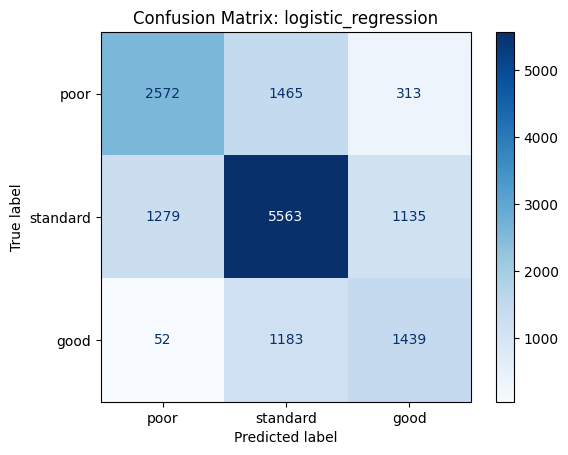

              precision    recall  f1-score   support

           0       0.64      0.74      0.69      4350
           1       0.82      0.56      0.67      7977
           2       0.47      0.80      0.60      2674

    accuracy                           0.66     15001
   macro avg       0.65      0.70      0.65     15001
weighted avg       0.71      0.66      0.66     15001



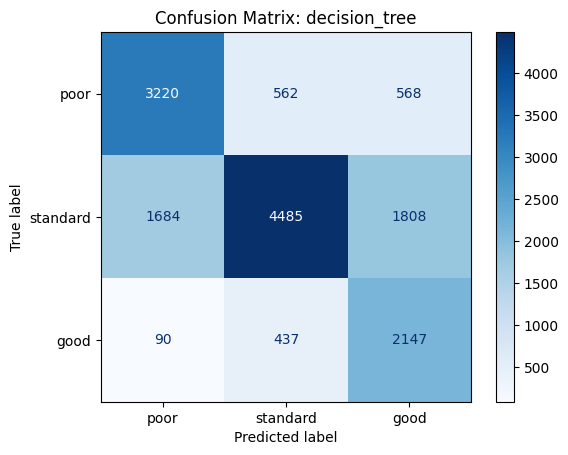

              precision    recall  f1-score   support

           0       0.65      0.77      0.70      4350
           1       0.85      0.57      0.68      7977
           2       0.49      0.82      0.61      2674

    accuracy                           0.67     15001
   macro avg       0.66      0.72      0.67     15001
weighted avg       0.73      0.67      0.68     15001



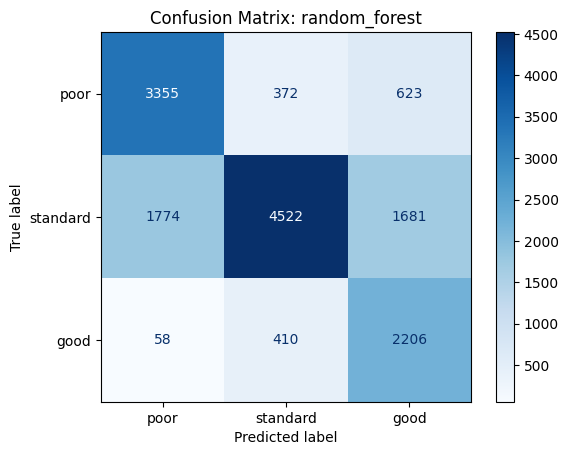

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      4350
           1       0.75      0.78      0.77      7977
           2       0.62      0.66      0.64      2674

    accuracy                           0.73     15001
   macro avg       0.71      0.71      0.71     15001
weighted avg       0.73      0.73      0.73     15001



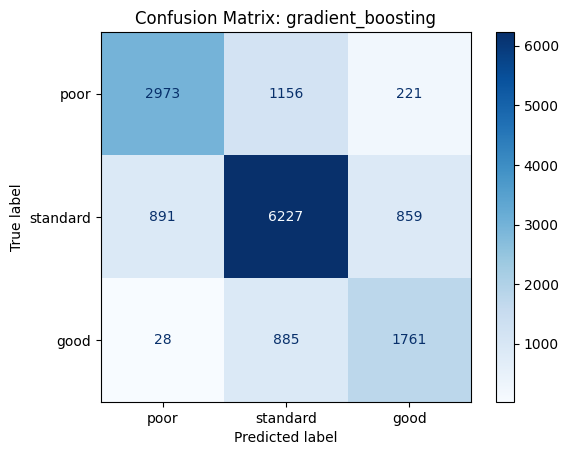

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      4350
           1       0.74      0.77      0.75      7977
           2       0.59      0.65      0.62      2674

    accuracy                           0.71     15001
   macro avg       0.69      0.69      0.69     15001
weighted avg       0.72      0.71      0.71     15001



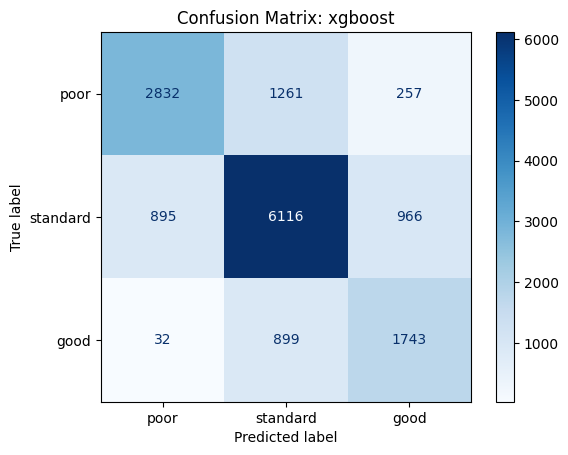

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
              precision    recall  f1-score   support

           0       0.75      0.63      0.68      4350
           1       0.72      0.76      0.74      7977
           2       0.56      0.62      0.59      2674

    accuracy                           0.70     15001
   macro avg       0.68      0.67      0.67     15001
weighted avg       0.70      0.70      0.70     15001



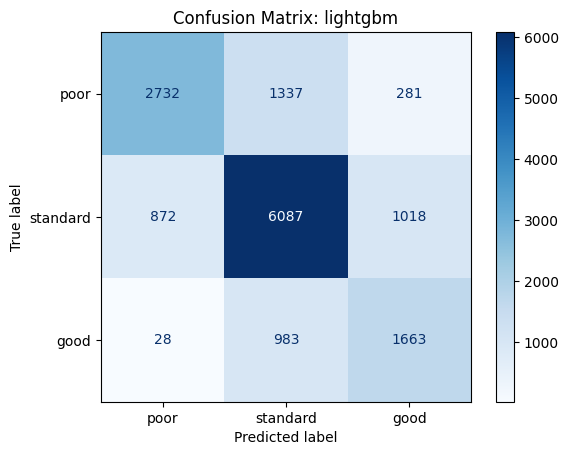

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      4350
           1       0.75      0.78      0.76      7977
           2       0.61      0.65      0.63      2674

    accuracy                           0.72     15001
   macro avg       0.70      0.70      0.70     15001
weighted avg       0.73      0.72      0.72     15001



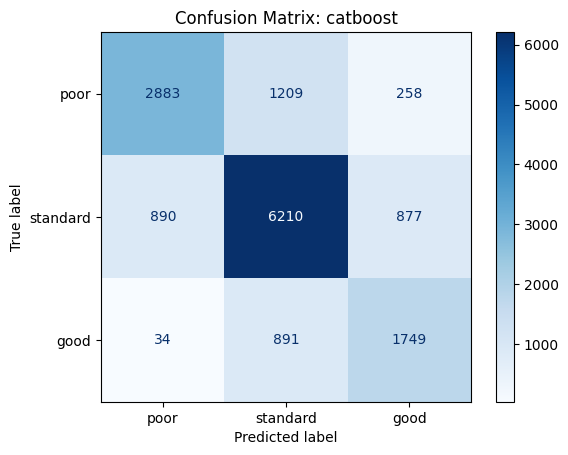

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      4350
           1       0.87      0.68      0.77      7977
           2       0.61      0.86      0.72      2674

    accuracy                           0.77     15001
   macro avg       0.75      0.80      0.76     15001
weighted avg       0.79      0.77      0.77     15001



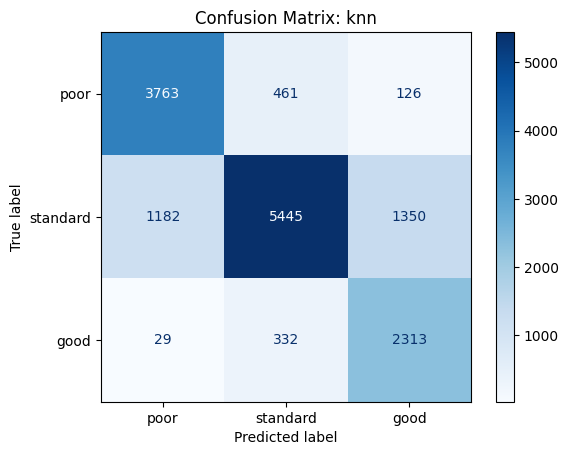

              precision    recall  f1-score   support

           0       0.70      0.70      0.70      4350
           1       0.74      0.71      0.73      7977
           2       0.58      0.65      0.62      2674

    accuracy                           0.70     15001
   macro avg       0.68      0.69      0.68     15001
weighted avg       0.70      0.70      0.70     15001



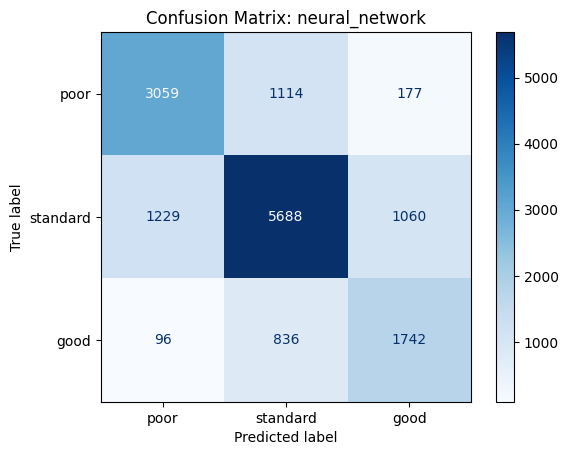

In [145]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_labels = ['poor', 'standard', 'good']

# Evaluate and plot confusion matrix for each best model
for model_name, model_data in results.items():
    best_model = model_data['best_model']
    
    # Predict on the test set
    y_val_pred = best_model.predict(X_val_final)

    print(classification_report(y_val_final, y_val_pred))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_val_final, y_val_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

# Model evaluation

To further evaluate our chosen best model, namely k-NN, we now run our model on the holdout test set. But first we train the model with both the training and validation set

In [140]:
# Get the best model (top row in the sorted table)
best_model_row = val_results_df.iloc[0]
best_model_name = best_model_row['model_name']
best_model_pipeline=create_pipeline(best_model_name,cleaning_rules)
best_params = results[best_model_name]['best_params']
best_model_pipeline.set_params(**best_params)
best_model = best_model_pipeline.fit(X_train_val_final, y_train_val_final)

/opt/anaconda3/envs/try5/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [141]:
from sklearn.metrics import classification_report

y_test_pred = best_model.predict(X_test_final)
report_str = classification_report(y_test_final, y_test_pred)
print("Classification Report:\n")
print(report_str)

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      4350
           1       0.88      0.70      0.78      7976
           2       0.66      0.88      0.75      2674

    accuracy                           0.79     15000
   macro avg       0.76      0.82      0.78     15000
weighted avg       0.81      0.79      0.79     15000



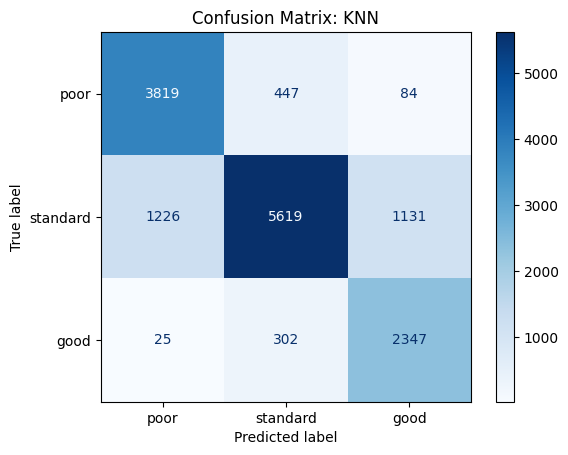

In [142]:
cm = confusion_matrix(y_test_final, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix: KNN')
plt.show()

On the held‐out test set, k‐NN’s strong performance holds: overall accuracy is 0.79 and the macro-averaged F1 rises slightly to 0.78, confirming the model’s generalization. Looking class by class, we still prioritize recall for Poor loans (class 0), where recall is 0.88 (precision 0.75). We catch the vast majority of bad loans, keeping default risk low even if we occasionally decline a good applicant. For Standard loans (class 1), precision is 0.88 with recall 0.70. When we allocate mid‐tier credit terms, we remain confident that borrowers truly belong in the medium‐risk segment, avoiding both under-pricing strong customers and over-extending to risky ones. Finally, for Good loans (class 2), recall stays high at 0.88, though precision (0.66) remains the lowest; this means we successfully identify most top-tier applicants but still admit some borderline cases at favorable rates. Overall, the test‐set metrics mirror the validation results, reinforcing that k-NN delivers the right balance of risk control and opportunity capture, even when evaluated on unseen data.

The confusion matrix shows that of 4 350 actual Poor loans, only 84 (≈2 %) were wrongly rated Good, while 447 were rated Standard. For the 7 976 Standard loans, 1 131 were bumped up to Good and 1 226 dropped to Poor. And among 2 674 real Good loans, just 25 were marked Poor and 302 Standard. In short, the riskiest error, calling a bad loan good, happens very rarely (84 out of 15 000), and most mistakes err on the side of being too cautious.

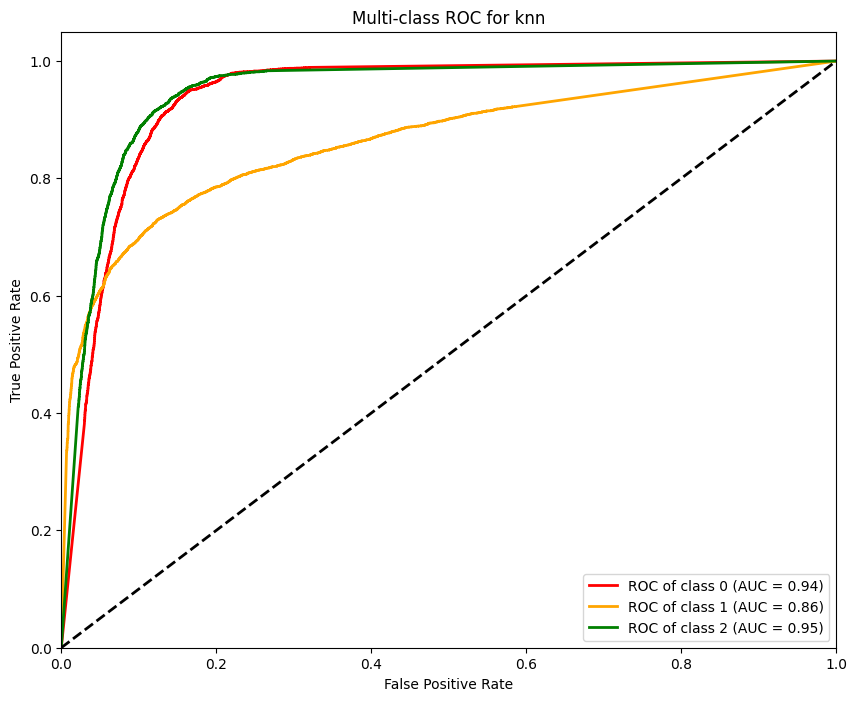

In [143]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics      import roc_curve, auc
import matplotlib.pyplot  as plt

# assume y_test_orig is your 1D array/Series of {0,1,2} labels
y_test_bin = label_binarize(y_test_final, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

# get predicted probabilities
y_score = best_model.predict_proba(X_test_final)

# compute per-class ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _   = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i]          = auc(fpr[i], tpr[i])

# plot
plt.figure(figsize=(10,8))
colors = ['red','orange','green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             color=colors[i],
             lw=2,
             label=f'ROC of class {best_model.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--',lw=2)
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'Multi-class ROC for {best_model_name}')
plt.legend(loc='lower right')
plt.show()


The multi-class ROC shows that k-NN separates Poor (class 0) and Good (class 2) loans extremely well (AUCs 0.94 and 0.95), with their curves hugging the top-left corner, while Standard loans (class 1) are trickier (AUC 0.86), the orange line sitting notably below the others. In practice this means we can very reliably flag bad and good borrowers, but our medium-risk segment still overlaps a bit with both extremes—something we might help further with feature engineering or class-specific thresholds. Overall, it shows that the model stil performs much better than random guessing.

In [144]:
from sklearn.metrics import classification_report

# building baseline model
baseline_model_name = "decision_tree"
baseline_pipeline = create_pipeline(baseline_model_name, cleaning_rules)
baseline_best_params = results[baseline_model_name]['best_params']
baseline_pipeline.set_params(**baseline_best_params)
baseline_model = baseline_pipeline.fit(X_train_val_final, y_train_val_final)
y_test_pred_baseline = baseline_model.predict(X_test_final)

# Generate and print the classification report
report_baseline = classification_report(y_test_final, y_test_pred_baseline)
print(f"Baseline model: {baseline_model_name}\n")
print("Classification Report:\n", report_baseline)


Baseline model: decision_tree

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.75      0.69      4350
           1       0.82      0.58      0.68      7976
           2       0.50      0.80      0.62      2674

    accuracy                           0.67     15000
   macro avg       0.65      0.71      0.66     15000
weighted avg       0.71      0.67      0.67     15000



The k-NN model delivers a clear upgrade over the decision tree: for Poor loans it boosts precision and recall by double-digit percentage points, greatly reducing both false alarms and missed defaults; for Standard loans it raises precision by around half a dozen points while substantially improving recall, so we’re both more accurate and more complete in that middle tier; and for Good loans it cuts mis-pricing errors by dramatically increasing precision and also lifts recall, ensuring we reward top-tier applicants more reliably. This across-the-board improvement makes k-NN a superior choice to the baseline.

In [151]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test_final, y_test_pred)
mmc_base = matthews_corrcoef(y_test_final,y_test_pred_baseline)

print(f"MCC (k-NN): {mcc:.4f}")
print(f"MCC (Decision Tree): {mmc_base:.4f}")
print("\nInterpretation:")
print(
    f"Our model’s MCC of {mcc:.4f} exceeds the baseline decision tree’s MCC of {mmc_base:.4f}, "
    "demonstrating improved classification performance.\n"
    "Since Matthews Correlation Coefficient takes into account all four types of classification outcomes\n "
    "(true and false positives and negatives) across all classes, it provides a balanced and reliable metric "
    "even when classes are imbalanced.\n"
    "The higher MCC suggests that our k-NN model not only achieves stronger overall accuracy but also delivers more consistent and trustworthy predictions \n"
    "across the different credit score categories."
)


MCC (k-NN): 0.6715
MCC (Decision Tree): 0.5033

Interpretation:
Our model’s MCC of 0.6715 exceeds the baseline decision tree’s MCC of 0.5033, demonstrating improved classification performance.
Since Matthews Correlation Coefficient takes into account all four types of classification outcomes
 (true and false positives and negatives) across all classes, it provides a balanced and reliable metric even when classes are imbalanced.
The higher MCC suggests that our k-NN model not only achieves stronger overall accuracy but also delivers more consistent and trustworthy predictions 
across the different credit score categories.


In [153]:
from sklearn.metrics import cohen_kappa_score

# --- Calculate Cohen’s Kappa ---
kappa = cohen_kappa_score(y_test_final, y_test_pred)
kappa_base = cohen_kappa_score(y_test_final, y_test_pred_baseline)

# --- Print results ---
print(f"Cohen’s Kappa (k-NN): {kappa:.4f}")
print(f"Cohen’s Kappa (Decision Tree): {kappa_base:.4f}\n")

print("Interpretation:")
print(
    f"Our model’s Cohen’s Kappa of {kappa:.4f} surpasses the baseline decision tree’s Kappa of {kappa_base:.4f}, "
    "indicating stronger agreement between our predictions and the actual credit scores.\n"
    "Cohen’s Kappa accounts for the possibility of agreement occurring by chance, making it more informative than accuracy alone,\n"
    "especially in multi-class settings like ours.\n"
    "The higher Kappa confirms that k-NN provides more meaningful and reliable classifications compared to the baseline model."
)


Cohen’s Kappa (k-NN): 0.6619
Cohen’s Kappa (Decision Tree): 0.4879

Interpretation:
Our model’s Cohen’s Kappa of 0.6619 surpasses the baseline decision tree’s Kappa of 0.4879, indicating stronger agreement between our predictions and the actual credit scores.
Cohen’s Kappa accounts for the possibility of agreement occurring by chance, making it more informative than accuracy alone,
especially in multi-class settings like ours.
The higher Kappa confirms that k-NN provides more meaningful and reliable classifications compared to the baseline model.


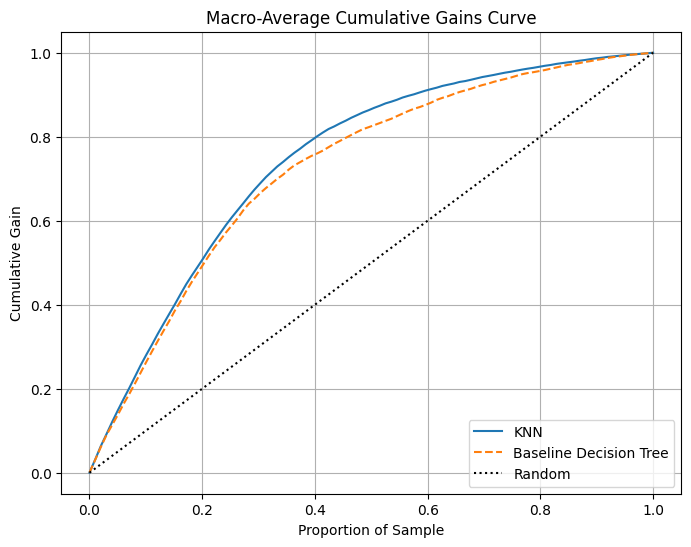

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

classes = [0, 1, 2]

# Binarize y_test into one-vs-rest format
y_test_bin = label_binarize(y_test_final, classes=classes)    

# Get predicted probabilities
y_score_model = best_model    .predict_proba(X_test_final)    
y_score_base  = baseline_model.predict_proba(X_test_final)    

# function to compute per-class pct_sample & gain
def cumulative_gain(y_true_cls, y_score_cls):
    df = pd.DataFrame({'y': y_true_cls, 'score': y_score_cls})
    df = df.sort_values('score', ascending=False).reset_index(drop=True)
    df['cum_pos']    = df['y'].cumsum()
    total_pos        = df['y'].sum()
    df['gain']       = df['cum_pos'] / total_pos
    df['pct_sample'] = (np.arange(len(df)) + 1) / len(df)
    return df['pct_sample'].values, df['gain'].values


grid = np.linspace(0, 1, 100)

# Compute per-class interpolated gains
gains_model = []
gains_base  = []
for i in range(len(classes)):
    pct_m, gain_m = cumulative_gain(y_test_bin[:, i], y_score_model[:, i])
    pct_b, gain_b = cumulative_gain(y_test_bin[:, i], y_score_base[:, i])
    gains_model.append(np.interp(grid, pct_m, gain_m))
    gains_base.append (np.interp(grid, pct_b, gain_b))

# Macro-average across classes
macro_gain_model = np.mean(gains_model, axis=0)
macro_gain_base  = np.mean(gains_base,  axis=0)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(grid, macro_gain_model, label='KNN')
plt.plot(grid, macro_gain_base,  '--', label='Baseline Decision Tree')
plt.plot([0, 1], [0, 1],     'k:', label='Random')
plt.xlabel('Proportion of Sample')
plt.ylabel('Cumulative Gain')
plt.title('Macro-Average Cumulative Gains Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


The cumulative gains curve highlights the advantage of using our k-NN model over the baseline decision tree. The k-NN curve consistently lies above the decision tree line, showing that for any given proportion of the sample, k-NN captures a higher proportion of positive cases. For example, with only around 40% of the sample, k-NN captures roughly 80% of the relevant outcomes—compared to less for the decision tree. Both models significantly outperform random guessing, but the added lift from k-NN confirms that it provides more value when ranking or prioritizing predictions, which is particularly useful in scenarios like targeted credit offerings or risk-based loan review.

# Model Interpretation

In [157]:
from sklearn.inspection import permutation_importance
perm_pipe = permutation_importance(best_model_pipeline, X_test_final, y_test_final, n_repeats=3, random_state=42, n_jobs=-1)

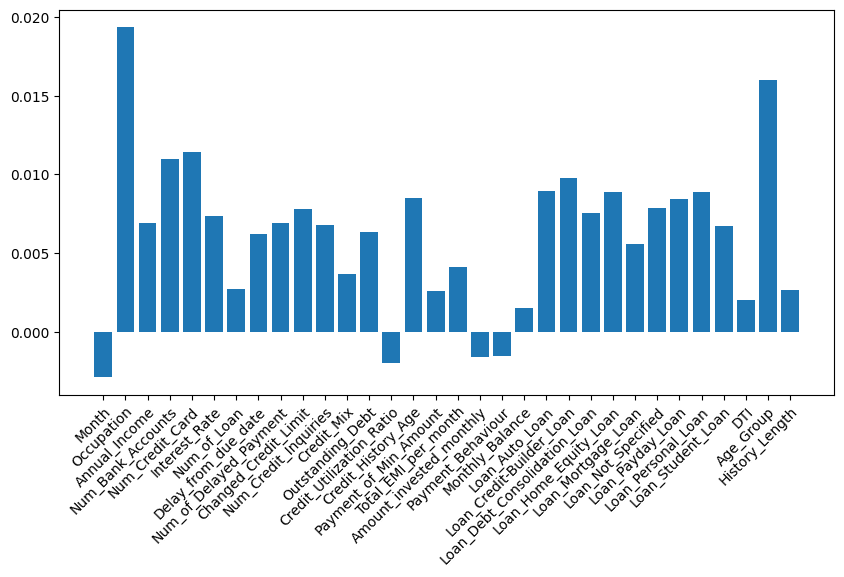

In [159]:
#plotting feature importance
feat_import_perm = perm_pipe.importances_mean
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=X_train_final.columns)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

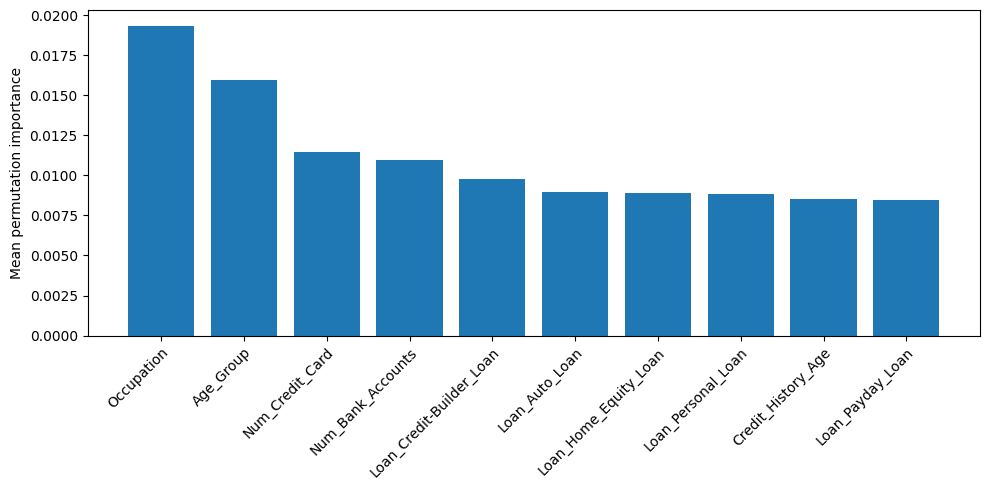

In [160]:
# Indices of the top 10 importances
top10_idx = np.argsort(feat_import_perm)[-10:][::-1]

# names of the top 10
top10_names  = X_train_final.columns[top10_idx]
top10_values = feat_import_perm[top10_idx]

# plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(10), top10_values, align="center")
ax.set_xticks(range(10))
ax.set_xticklabels(top10_names, rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Mean permutation importance")
plt.tight_layout()
plt.show()


In [ ]:
import shap
import pandas as pd


# Extract the preprocessing pipeline and classifier
preprocessor = best_model.named_steps['preprocessor']
classifier   = best_model.named_steps['classifier']


X_test_proc = preprocessor.transform(X_test_final)

# transformed feature names
feat_names = preprocessor.get_feature_names_out()


X_df = pd.DataFrame(X_test_proc, columns=feat_names)

# Create a small k-means background dataset (20 centroids)
background = shap.kmeans(X_df, 20)

# Instantiate the KernelExplainer using predict_proba
explainer = shap.KernelExplainer(
    classifier.predict_proba,  
    background                  
)

# Compute SHAP values
shap_values = explainer.shap_values(
    X_df,
    nsamples="auto"            
)


In [ ]:
import shap
import numpy as np # Ensure NumPy is imported
import matplotlib.pyplot as plt
import pandas as pd # Ensure Pandas is imported

# --- Ensure these variables are already defined in your environment ---
# shap_values_from_explainer: The 3D NumPy array of SHAP values.
# X_explain: The DataFrame used for SHAP explanations.
# classifier: Your trained classifier model.
# --- Example (make sure your actual variable names are used) ---
# shap_values_from_explainer = your_shap_output_variable_name
# X_explain = your_data_frame_variable_name
# classifier = your_classifier_variable_name

# Define how many top features to display in each plot
num_features_to_display = 20

# --- Start of Streamlined Plotting Code ---

print(f"--- Generating SHAP Summary Plots for Each Class (plot_type='dot') ---")
print(f"Assuming 'shap_values_from_explainer' is a 3D NumPy array (num_samples, num_features, num_classes).")
print(f"Using X_explain with shape: {X_explain.shape}") # Should be (num_samples, num_features)
print(f"Classifier classes: {classifier.classes_}")    # Should match the 3rd dimension of shap_values_from_explainer

for i, class_name_label in enumerate(classifier.classes_):
    print(f"\n--- Plotting for Class: {class_name_label} (Index {i}) ---")
    
    # Slice the 3D array to get SHAP values for the current class i
    # This extracts a 2D array (num_samples, num_features)
    shap_values_for_class_i = shap_values_from_explainer[:, :, i]
    
    print(f"Shape of SHAP values being plotted for class '{class_name_label}': {shap_values_for_class_i.shape}")

    # Call SHAP's summary plot
    shap.summary_plot(
        shap_values_for_class_i,  # Expected shape: (num_samples, num_features)
        X_explain,                # Expected shape: (num_samples, num_features)
        plot_type='dot',
        max_display=num_features_to_display,
        show=False                # Delay showing to add title before plt.show()
    )
    plt.title(f"SHAP Summary Plot for Class: {class_name_label}")
    plt.show()

print("\n--- Plotting complete ---")